<a href="https://colab.research.google.com/github/solobala/FEML23/blob/master/FEML27_DZ8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашнее задание к занятию «Поиск выбросов и генерация новых признаков» обновленное

**Преподаватель**: Юлия Пономарева, Егор Шишковец

**Цель**: Изучить применение методов по поиску выбросов в данных, попрактиковаться в обработке экстремальных значений.

**Описание задания**:
В домашнем задании нужно решить задачу классификации типа стекол. Данные для обучения моделей можно скачать с сайта. Целевая переменная – тип стекла «Type». Остальные признаки описывают химические элементы в составе материала. Датасет нужно исследовать на наличие выбросов, провести EDA.

# 0. Установка пакетов, импорт библиотек и пользовательские функции


In [1]:
! pip install pyod 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install adjdatatools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install -q kaggle # Делаем 1 раз

In [4]:
import pandas as pd
import numpy as np
from numpy import std, mean
from numpy.random import seed

from scipy.stats import shapiro, chi2
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline,make_pipeline

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from imblearn.over_sampling import SMOTE
from collections import Counter

from pyod.models.ecod import ECOD
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from pyod.models.lof import LOF
from pyod.models.knn import KNN

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)    


In [5]:
def shapiro_test(df,names):
    """
    Служебная функция для вывода информации по тесту Шапиро-Уилкса
    """
    seed(1)
    for name in names:
        stat, p = shapiro(df[name])
        print(name)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        alpha = 0.05
        if p > alpha:
            print('Предположительно нормальное распределение (Недостаточно данных, чтобы отвергнуть H0)')
        else:
            print('Отвергаем H0 о нормальности распределения')
        print()

In [6]:
def draw_plot(X, names, type):
  """
  служебная функция для визуализации распределения признаков, 
  построения боксплотов и графиков квантиль - квантиль.
  помогает визуально оценить нормальность распределения и
  наличие выбросов
  """
  n= len(names)
  seed(1)
  f, ax = plt.subplots(nrows=1, ncols=n, figsize=(22,2))
  i=0
  for key, value in names.items():
    if type == 'distplot':
      _ = sns.distplot(x=X[key],  ax=ax[i])
    elif type == 'boxplot':
      _ = sns.boxplot(x=X[key],  ax=ax[i])
    elif type == 'qqplot':
      _ = qqplot(data=X[key], line='s', ax=ax[i])
    elif type == 'lineplot':
      _ = sns.lineplot(x=X[key], palette="tab10", linewidth=2.5, ax=ax[i])  
    else:
      pass
    ax[i].set_title(value)
    # ax[i].grid(True)
    ax[i].minorticks_on()

    #  Определяем внешний вид линий основной сетки:
    ax[i].grid(which='major',
        color = 'r', 
        linestyle = '-')

    #  Определяем внешний вид линий вспомогательной
    #  сетки:
    ax[i].grid(which='minor', 
        color = 'k', 
        linestyle = ':')
    i+=1

In [7]:
def get_transform(X, num_features):
  """
  Служебная функция для визуализации распределения числовых признаков 
  после различной трансформации
  """
  for feature in num_features:

    X_tmp=X[feature]

    distributions = [
        (f"{feature}: Unscaled data", X_tmp),\
        (f"{feature}: standard", 
        StandardScaler().fit_transform(X_tmp.to_numpy().reshape(-1,1))),

        (f"{feature}: min-max", \
        MinMaxScaler().fit_transform(X_tmp.to_numpy().reshape(-1,1))),

        (f"{feature}: max-abs", \
        MaxAbsScaler().fit_transform(X_tmp.to_numpy().reshape(-1,1))),

        (f"{feature}: robust", \
        RobustScaler(quantile_range=(25, 75)).fit_transform(X_tmp.to_numpy().reshape(-1,1))),

        (f"{feature}: power tr. (Yeo-Johnson)", \
        PowerTransformer(method="yeo-johnson").fit_transform(X_tmp.to_numpy().reshape(-1,1))),

        (f"{feature}: quantile tr.uniform",
            QuantileTransformer(output_distribution="uniform").fit_transform(X_tmp.to_numpy().reshape(-1,1)),
        ),
        (f"{feature}: quantile tr. gaussian",
            QuantileTransformer(output_distribution="normal").fit_transform(X_tmp.to_numpy().reshape(-1,1)),
        ),
        (f"{feature}: L2 normalizing", Normalizer().fit_transform(X_tmp.to_numpy().reshape(-1,1))),
    ]
    dist_dict={}
    for item in distributions:
      dist_dict[item[0]]=item[0]

    transform_results = pd.DataFrame(list(zip( 
                                              distributions[0][1], 
                                              distributions[1][1],
                                              distributions[2][1],
                                              distributions[3][1],
                                              distributions[4][1],
                                              distributions[5][1],
                                              distributions[6][1],
                                              distributions[7][1],
                                              distributions[8][1],
        
                                        )), 
                                    columns = [
                      distributions[0][0], 
                      distributions[1][0],
                      distributions[2][0],
                      distributions[3][0],
                      distributions[4][0],
                      distributions[5][0],
                      distributions[6][0],
                      distributions[7][0],
                      distributions[8][0],
        
      
                                            ])
  # визуализация распределения признака  после  трансформации
    draw_plot(transform_results, dist_dict, 'distplot')

In [8]:
def sigma_3(tmp,names, percent):
  """
  Служебная функция для поиска выбросов признака по правилу 3 сигм
  при нормальном или близком к ноормальному распределению
  tmp - датасет
  names - названия признаков
  percent - допустимый процент выбросов
  Возвращает % выбросов и их индексы
  """
  outliner_results=[]
 
  for name in names:
    start_len = tmp.shape[0]
    result=dict()
    indices=[]
    std = tmp[name].std()
    mean = tmp[name].mean()
    left_board = mean - 3 * std
    right_board  = mean + 3 * std
    indices = tmp.loc[(tmp[name]<=left_board) | (tmp[name]>=right_board)].index.to_list()   # Это выбросы 
    share = len(indices)/start_len*100
    # result['feature']=name
    result['indices']=indices
    # result['share'] = share
    outliner_results.append(result)

  indices = set() 
  for item in outliner_results:
    indices = indices.union(item['indices']) # объединяем выбросы по всем признакам
  share = (len(indices))/start_len * 100
  # возвращает % выбросов, множество индексов выбросов

  return share, indices

In [9]:
def interquartile_range(tmp,names,percent):
  """
  Служебная функция для поиска выбросов признака по межквартильному размаху IQR
  при нормальном или близком к ноормальному распределению
  tmp - датасет
  names - названия признаков
  percent - допустимый процент выбросов
  Возвращает % выбросов и их индексы
  """
  outliner_results=[]
  start_len = len(tmp)
  
  for name in names:
    result=dict()
    q1 = tmp[name].quantile(0.25)
    q3 = tmp[name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr) 
    upper_bound = q3 + (1.5 * iqr)

    indices = tmp.loc[(tmp[name]<=lower_bound) | (tmp[name]>=upper_bound)].index.to_list()   
    share = len(indices)/start_len*100
    # result['feature']=name
    result['indices']=indices
    # result['share'] = share
    outliner_results.append(result)

  indices = set() 
  for item in outliner_results:
    indices = indices.union(item['indices']) 
  share = (len(indices))/start_len * 100    
  
  return share, indices

In [10]:
def percentile_range(tmp,names,percent):
  """
  Служебная функция для поиска выбросов признака за пределами диапазона 
  процентилей (0.5, 99.5)
    tmp - датасет
  names - названия признаков
  percent - допустимый процент выбросов
  Возвращает % выбросов и их индексы
  """
  outliner_results=[]
  start_len = len(tmp)
  
  for name in names:
    result=dict()
    lower_limit, upper_limit = np.percentile(a=tmp[name], q=[0.5, 99.5])
   
    indices = tmp.loc[(tmp[name]<=lower_limit) | (tmp[name]>=upper_limit)].index.to_list()   
    share = len(indices)/start_len*100
    # result['feature']=name
    result['indices']=indices
    # result['share'] = share
    outliner_results.append(result)

  indices = set() 
  for item in outliner_results:
    indices = indices.union(item['indices']) 
  share = (len(indices))/start_len * 100   
 
  return share, indices

In [11]:
def mahalanobis(x= None , data= None , cov= None ):
  """
  Функция для расчета расстояния Maхаланобиса
  Расстояние Махаланобиса — это расстояние между двумя точками в 
  многомерном пространстве. Оно часто используется для поиска выбросов 
  в статистическом анализе, включающем несколько переменных
  https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%9C%D0%B0%D1%85%D0%B0%D0%BB%D0%B0%D0%BD%D0%BE%D0%B1%D0%B8%D1%81%D0%B0
  """
  x_mu = x - np.mean(data)
  if not cov:
    cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
  return mahal.diagonal()

In [12]:
def get_learn(df,random_seed, method, model, flag):
  """
  Служебная функция. выполняет:
    - разделение на Train и test
    - обучение модели
    - расчет метрик качества classification_report
    возвращает название метода удаления выбросов, 
    classification_report в виде словаря и отдельно - accuracy
    df- датафрейм, random_seed - фиксатор генератора случ.чисел, 
    method - название метода поиска выбросов, model - модель классификатора,
    flag - признак печати результатов (True/False)
  """
  X = df.drop(columns=['target'])
  y = df['target']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
  
  rf = model                                     
  rf.fit(X_train, y_train)
  y_pred = rf.predict(X_test)
  target_names = ['building_windows_float_processed', \
                'building_windows_non_float_processed',\
                'vehicle_windows_float_processed', \
                'containers', 'tableware', 'headlamps']
  if flag:              
    print(
      f"Classification report {method}\n")
    print(
      f"{classification_report(y_test, y_pred, target_names=target_names)}\n"
    )
      # Confusion matrix

    fig, ax = plt.subplots(figsize=(6, 3))

    cm = confusion_matrix(y_test, y_pred)
    cmp = ConfusionMatrixDisplay(cm, display_labels=target_names)
    # plt.rcParams.update({'font.size': 10})
    # plt.tick_params(axis='both', which='major', labelsize=10)
    cmp.plot(ax=ax, xticks_rotation='vertical')
    plt.show()
  # Отчет полностью
  report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True )
  a = report['accuracy']
 
  return method,  report, a

# 1. Получите данные и загрузите их 

In [ ]:
# Это напоминалка - приглашение загрузить в сессионное хранилище свой kaggle.json. Ключ стерла!
from google.colab import files
files.upload()

In [14]:
! mkdir ~/.kaggle # Создаем каталог .kaggle  1 раз, для того, чтобы сюда положить ключ kaggle.json, который получаем на Kaggle при регистрации
! cp kaggle.json ~/.kaggle/  # кладем ключ
! chmod 600 /root/.kaggle/kaggle.json # засекречиваем. К сожалению, это все только на время сеанса
!kaggle datasets list -s 'glass' # Сюда вместо happiness - люббое ключевое слово

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                       title                                          size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
uciml/glass                                               Glass Classification                            3KB  2017-01-27 17:27:48          31473        312  0.8235294        
danushkumarv/glass-identification-data-set                Glass Identification Data Set                   4KB  2022-09-19 06:29:08            729         52  1.0              
jeffheaton/glasses-or-no-glasses                          Glasses or No Glasses                           6GB  2020-04-17 23:53:58           5213         75  0.88235295       
nilimajauhari/glassdoor-analyze-gender-pay-gap            Gl

In [15]:
!kaggle datasets download -d 'uciml/glass'  # А это нужный датасет

glass.zip: Skipping, found more recently modified local copy (use --force to force download)


In [16]:
!unzip glass.zip

Archive:  glass.zip
replace glass.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [17]:
df = pd.read_csv('/content/glass.csv')
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Атрибуты:

* Id number: 1 to 214 (removed from CSV file)
* RI: refractive index
* Na: Sodium (unit measurement: weight percent in corresponding oxide, as are  attributes 4-10)
* Mg: Magnesium
* Al: Aluminum
* Si: Silicon
* K: Potassium
* Ca: Calcium
* Ba: Barium
* Fe: Iron
* Type of glass: (class attribute)
-- 1 - building_windows_float_processed
-- 2 - building_windows_non_float_processed
-- 3 - vehicle_windows_float_processed
-- 5 - containers
-- 6 - tableware
-- 7 - headlamps

In [18]:
class_labels ={1: 'building_windows_float_processed', 
               2: 'building_windows_non_float_processed',
               3: 'vehicle_windows_float_processed',
               5: 'containers',
               6: 'tableware',
               7: 'headlamps'
               }

In [19]:
features_dict=dict()
features_dict['RI'] = 'refractive index'
features_dict['Na'] =  'Sodium'
features_dict['Mg'] = 'Magnesium'
features_dict['Al'] = 'Aluminum'
features_dict['Si'] = 'Silicon'
features_dict['K'] = 'Potassium'
features_dict['Ca'] = 'Calcium'
features_dict['Ba'] = 'Barium'
features_dict['Fe'] = 'Iron'

# 2. Проведите первичный анализ.

In [20]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [21]:
df.info() # Пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [22]:
# проверим, нет ли пропусков, обозначенных "?" 
flag=True
for column in df.columns:
  if('?')  in list(df[column].value_counts()):
    print(column)
    flag = False
if flag:
    print('пропусков "?" нет')

пропусков "?" нет


в датасете 6 типов стекла ( 6 классов), Классы несбалансированы. Существующие метки классов не отражают реальное соотношение между классами.Перекодируем метки классов с учетом соотношений:

In [23]:
df['target'] = df['Type'].apply(lambda z: class_labels[z])

In [24]:
df.drop(columns=['Type'], inplace=True)

У признака 'Ba' основное к-во значений -0, другие значения встрчаются 1-2 раза Есть смысл превратить его в категориальную переменную со значениям 0( бария нет) или 1 (барий есть). ТО же самое  -для Fe

In [25]:
df['Ba']=df['Ba'].apply(lambda z: 0 if z==0 else 1)

In [26]:
df['Fe']=df['Fe'].apply(lambda z: 0 if z==0 else 1)

In [27]:
num_features_dict=dict()
num_features_dict['RI'] = 'refractive index'
num_features_dict['Na'] =  'Sodium'
num_features_dict['Mg'] = 'Magnesium'
num_features_dict['Al'] = 'Aluminum'
num_features_dict['Si'] = 'Silicon'
num_features_dict['K'] = 'Potassium'
num_features_dict['Ca'] = 'Calcium'

# 3. Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.

In [28]:
random_seed = 42
percent = 10

In [29]:
X=df.drop(columns=['target'])
y=df['target']

#4. Обучите модель дерева решений RandomForestClassifier на обучающем множестве.

# 5. Для тестового множества предскажите тип стекла и сравните с истинным значением, посчитав точность предсказания модели (accuracy).

Classification report baseline

                                      precision    recall  f1-score   support

    building_windows_float_processed       0.73      1.00      0.85        11
building_windows_non_float_processed       0.83      0.71      0.77        14
     vehicle_windows_float_processed       1.00      0.50      0.67         4
                          containers       0.80      1.00      0.89         8
                           tableware       1.00      0.67      0.80         3
                           headlamps       1.00      0.67      0.80         3

                            accuracy                           0.81        43
                           macro avg       0.89      0.76      0.80        43
                        weighted avg       0.84      0.81      0.81        43




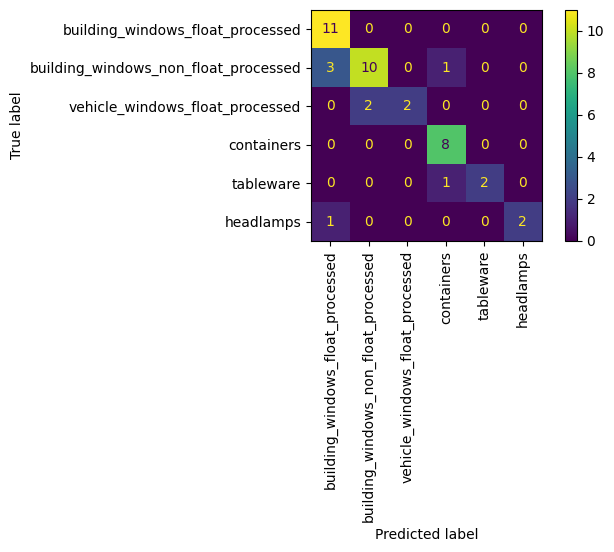

In [30]:
method,  report, a = get_learn(df,random_seed, 'baseline', RandomForestClassifier(criterion='entropy',random_state=random_seed), flag=True)

Вышла приемлемая accuracy по датасету в целом. но если посмотреть на отдельные классы, то  building_windows_float_processed имеет по сравнению с другими классами заниженную precision(0.73),  а vehicle_windows_float_processed  -  заниженную recall (0.5). Попробуем исправить ситуацию, поработав с трансформацией признаков и с выбросами 

In [31]:
exper=pd.DataFrame(columns=['model', 'class', 'precision', 'recall', 'f1-score', '% outliers','ind_outliers'])
for k1, v1 in report.items():
  if k1 in class_labels.values():
    exper.loc[len(exper.index)] = [method, k1,  v1['precision'], v1['recall'], v1['f1-score'],0.0,[]]
# exper.head() 

In [32]:
df_results = pd.DataFrame(columns=['method', 'share', 'indices',  'accuracy'])
df_results.loc[len(df_results.index)] = [method, 0., set(), a]
# df_results.head()

# 6. Обработайте выбросы в данных.

## а) Визуализируйте распределение значений для каждой переменной. Можно использовать функции sns.boxplot, sns.distplot. Есть ли признаки с нормальным распределением?

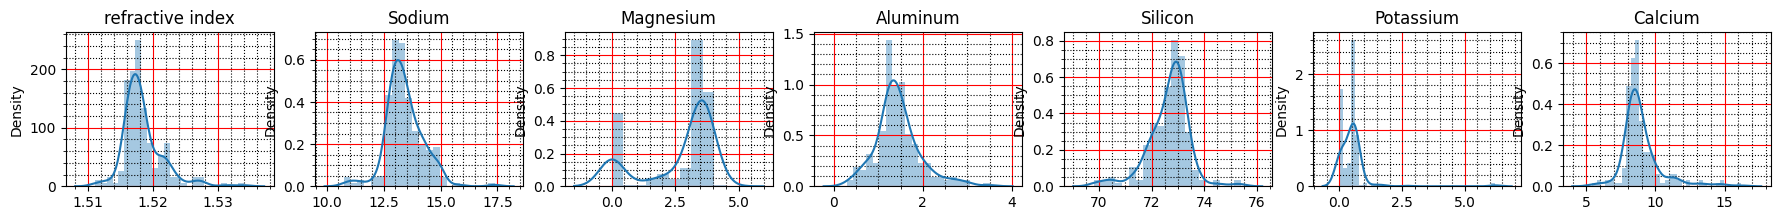

In [33]:
draw_plot(X, num_features_dict, 'distplot')

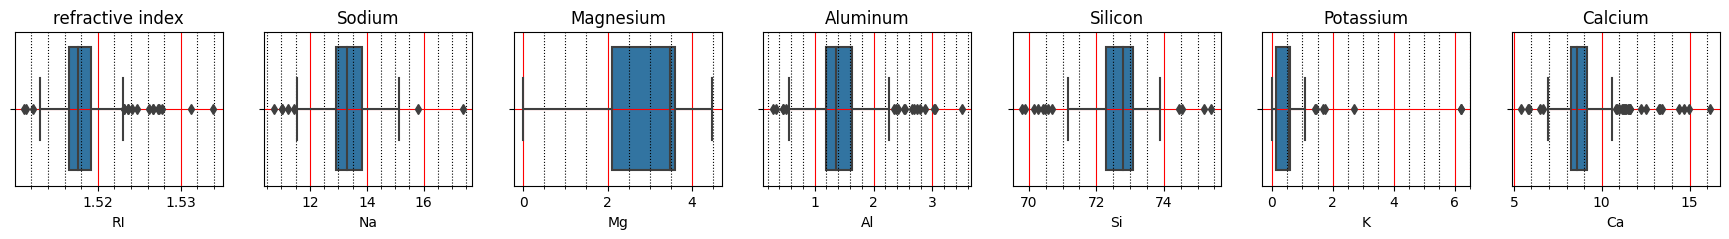

In [34]:
draw_plot(X, num_features_dict, 'boxplot')

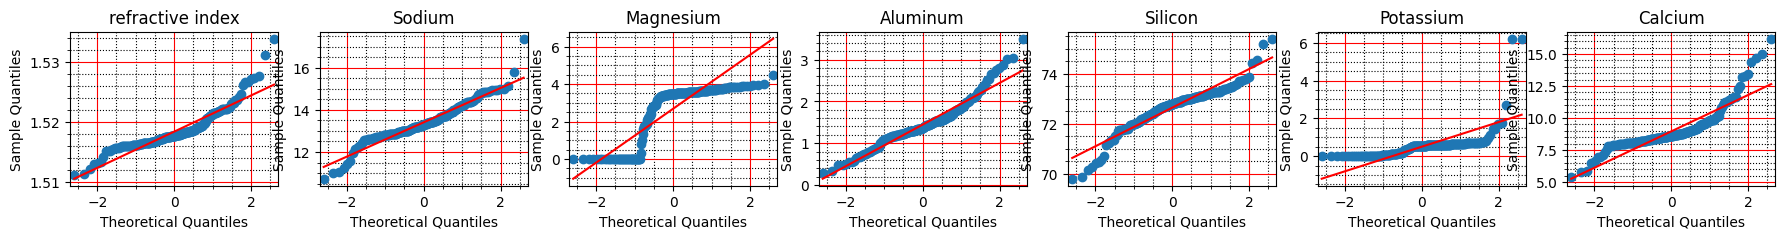

In [35]:
draw_plot(X, num_features_dict, 'qqplot')

In [36]:
shapiro_test(df, num_features_dict.keys())

RI
Statistics=0.868, p=0.000
Отвергаем H0 о нормальности распределения

Na
Statistics=0.946, p=0.000
Отвергаем H0 о нормальности распределения

Mg
Statistics=0.699, p=0.000
Отвергаем H0 о нормальности распределения

Al
Statistics=0.943, p=0.000
Отвергаем H0 о нормальности распределения

Si
Statistics=0.920, p=0.000
Отвергаем H0 о нормальности распределения

K
Statistics=0.442, p=0.000
Отвергаем H0 о нормальности распределения

Ca
Statistics=0.794, p=0.000
Отвергаем H0 о нормальности распределения



Визуально на боксплотах определяются выбросы у всех признаков, кроме Mg. Среди признаков нет ни одного с нормальным распределением. Значит традиционные для нормального распределения способы удаления выбросов по правилу 3 сигма или по межквартильному размаху нельзя применять без предварительной обработки признаков с целью "нормализации" распределения.

Особенности даиасета:
* Малое число записей
* Большое число меток классов
* Значительная несбалансированность классов ( есть опасность удалить класс при удалении выбросов
* Метки классов закодированы цифрами, которые не несут в себе смысла ( к тому же 1 класс пропущен в датасете). Нужно перекодировать
* Все признаки не имеют нормального распределения. После трансформации к нормальному распределению не удалось привести 3 признака с наибольшим к-вом выбросов.

### Попытаемся сбалансировать классы с помощью SMOTE

In [37]:
sm = SMOTE(random_state=random_seed, k_neighbors=5)
X,y = sm.fit_resample(X, y)

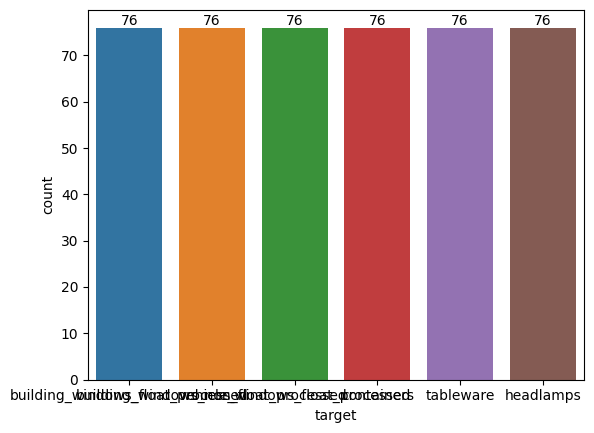

In [38]:
ax = sns.countplot(x=y)
for c in ax.containers:
    ax.bar_label(c)

In [39]:
y_tmp=y.to_frame()
y_tmp.shape

(456, 1)

In [40]:
data=pd.concat([X,y_tmp], axis=1) # Новый датафрейм после оверсэмплинга. Дальше работаем с ним
data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,target
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0,0,building_windows_float_processed
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0,0,building_windows_float_processed
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0,0,building_windows_float_processed
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0,0,building_windows_float_processed
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0,0,building_windows_float_processed


In [41]:
X = data.drop(columns=['target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [42]:
num_features = num_features_dict.keys()

### Проверим разные варианты приведения признаков к нормальному распределению


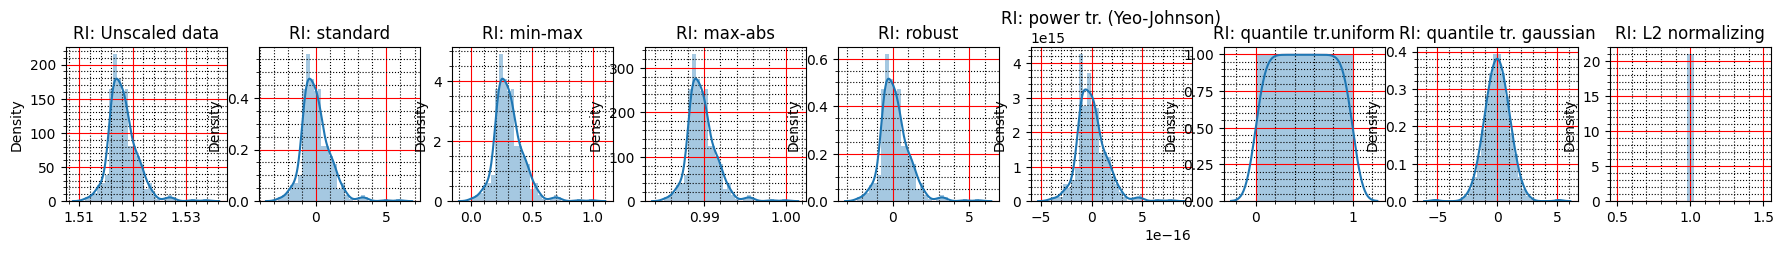

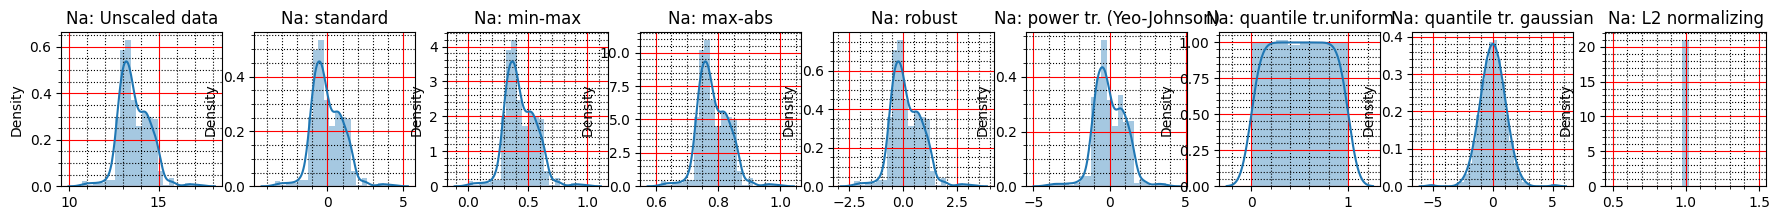

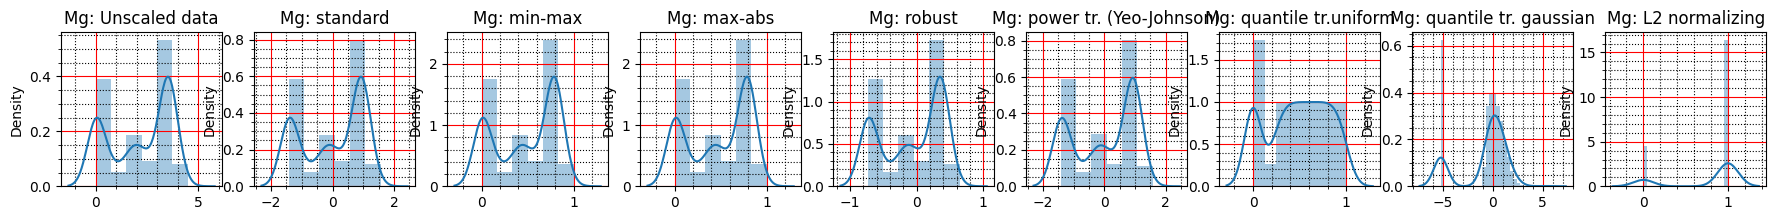

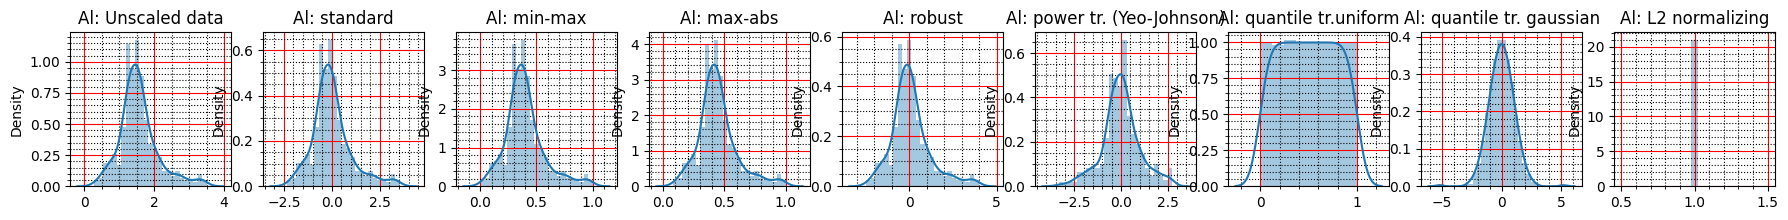

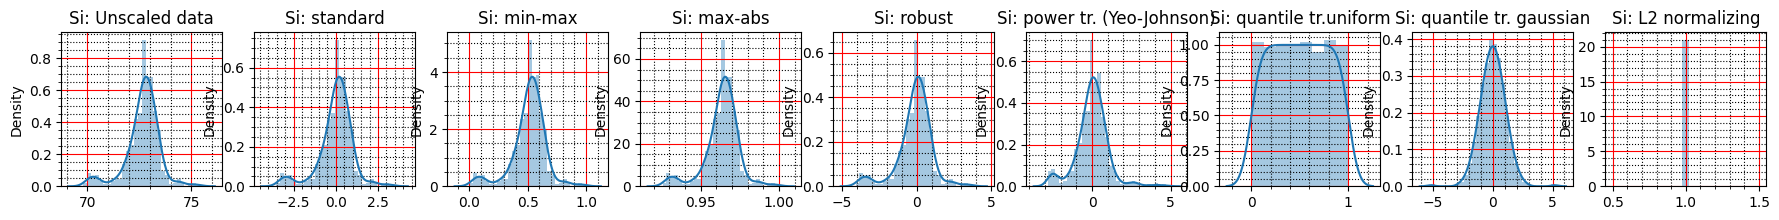

In [ ]:
get_transform(X, num_features)

Для большинства признаков удовлетворительной трансформацией видится QuantileTransformer(output_distribution="normal"). Однако для Mg и K распределения, близкого к нормальному, добиться   не удалось

In [ ]:
# Пайплайн комбинированной трансформации признаков с помощью StandardScaler и QuantileTransformer
scal_features = ['Mg', 'K','Ba', 'Fe']
quant_features = ['RI',	'Na',	'Al',	'Si',	'Ca']   

scal_transformer = Pipeline(
    steps=[ ("scaler", StandardScaler())]
)

quant_transformer = Pipeline(steps=[ ("scaler", QuantileTransformer())])
combine_preprocessor = ColumnTransformer(
    transformers=[
        ("scal", scal_transformer, scal_features),
        ("quant", quant_transformer, quant_features),
]
)     

In [ ]:
pipelines = []
pipelines.append(('CombineTransformer', Pipeline([("combine_preprocessor", combine_preprocessor),
                                     ('RFC', RandomForestClassifier())])))

### Проверим эффективность  трансформации

Classification report CombineTransformer

                                      precision    recall  f1-score   support

    building_windows_float_processed       0.88      0.82      0.85        17
building_windows_non_float_processed       0.94      0.89      0.92        19
     vehicle_windows_float_processed       1.00      1.00      1.00        10
                          containers       1.00      1.00      1.00        15
                           tableware       1.00      1.00      1.00        11
                           headlamps       0.91      1.00      0.95        20

                            accuracy                           0.95        92
                           macro avg       0.95      0.95      0.95        92
                        weighted avg       0.95      0.95      0.94        92




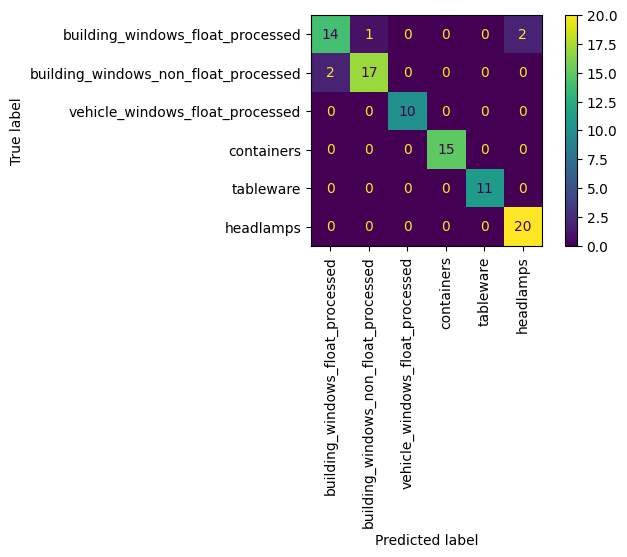

In [46]:
for name, model in pipelines:
  name,  report, a = get_learn(data,random_seed, name, RandomForestClassifier(criterion='entropy',random_state=random_seed), flag=True )
  df_results.loc[len(df_results.index)] = [name, 0., set(), a]

  for k1, v1 in report.items():
    if k1 in class_labels.values():
      exper.loc[len(exper.index)] = [name, k1,  v1['precision'], v1['recall'], v1['f1-score'], 0.0, []]


In [47]:
   # .format('{:.4f}', na_rep='-', subset=['precision', 'recall', 'f1-score']) \ !!! ПОчему-то не удается вывести нужное к-во знаков после запятой!!
exper.sort_values(by=['class', 'precision','recall'], ascending=False).style\
         .format(precision=2, subset=['precision', 'recall', 'f1-score', '% outliers']) \
        .format({'model': lambda x:x.lower(),
                'class': lambda x:x.lower()
          }) \
 .highlight_null(null_color='lightgrey') \
 .highlight_max(color='yellowgreen', subset=['precision', 'recall', 'f1-score', '% outliers']) \
 .highlight_min(color='coral', subset=['precision', 'recall', 'f1-score', '% outliers']) 


,model,class,precision,recall,f1-score,% outliers,ind_outliers
8,combinetransformer,vehicle_windows_float_processed,1.000000,1.000000,1.000000,0.000000,[]
2,baseline,vehicle_windows_float_processed,1.000000,0.500000,0.666667,0.000000,[]
10,combinetransformer,tableware,1.000000,1.000000,1.000000,0.000000,[]
4,baseline,tableware,1.000000,0.666667,0.800000,0.000000,[]
5,baseline,headlamps,1.000000,0.666667,0.800000,0.000000,[]
11,combinetransformer,headlamps,0.909091,1.000000,0.952381,0.000000,[]
9,combinetransformer,containers,1.000000,1.000000,1.000000,0.000000,[]
3,baseline,containers,0.800000,1.000000,0.888889,0.000000,[]
7,combinetransformer,building_windows_non_float_processed,0.944444,0.894737,0.918919,0.000000,[]
1,baseline,building_windows_non_float_processed,0.833333,0.714286,0.769231,0.000000,[]


Вариант после оверсэмплинга с комбинированной трансформацией значительно повысил метрики качества без всякого удаления выбросов!

### Масштабирование данных методом скорректированного интервала (эксперимент!)

In [48]:
from adjdatatools.preprocessing import AdjustedScaler
data_tmp=data.drop(columns=['target']).copy()
new_scaler = AdjustedScaler()
new_scaler.fit(data_tmp)
scaled_data_frame = new_scaler.transform(data_tmp)

In [49]:
X_tmp = scaled_data_frame
y_tmp = y.copy()

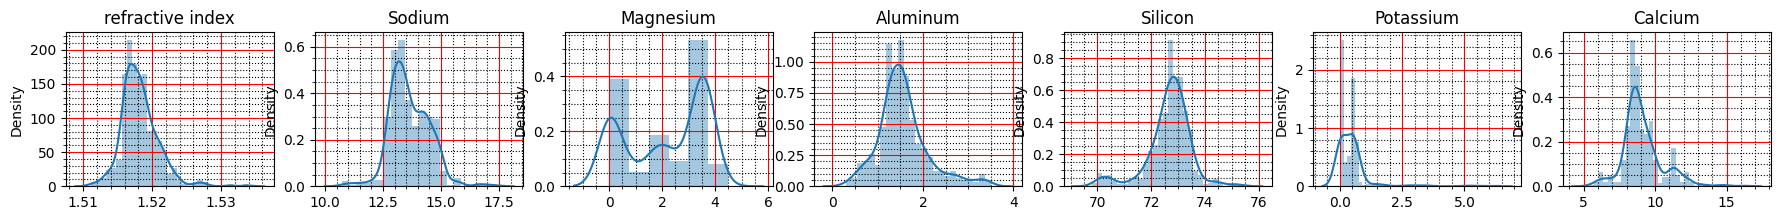

In [50]:
draw_plot(X,  num_features_dict, 'distplot') # это распределение признаков до обработки, для сравнения

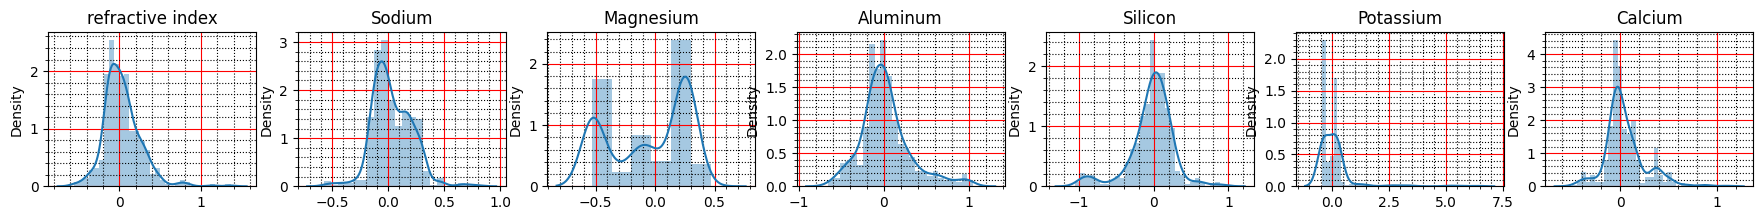

In [51]:
draw_plot(X_tmp,  num_features_dict, 'distplot') # А это после

видно, что после обработки произошло центрирование распределения, характер не изменился

In [52]:
t=pd.concat([X_tmp, y_tmp], axis=1)

In [53]:
method,  report, a = get_learn(t,random_seed, 'adjdatatools', RandomForestClassifier(criterion='entropy',random_state=random_seed), flag=False )
df_results.loc[len(df_results.index)] = [method, 0., set(),a]


In [54]:
for k1, v1 in report.items():
    if k1 in class_labels.values():
      exper.loc[len(exper.index)] = [method, k1,  v1['precision'], v1['recall'], v1['f1-score'], 0.0,[]]


In [55]:
exper.sort_values(by=['class', 'precision','recall'], ascending=False).style\
         .format(precision=2, subset=['precision', 'recall', 'f1-score', '% outliers']) \
        .format({'model': lambda x:x.lower(),
                'class': lambda x:x.lower()
          }) \
 .highlight_null(null_color='lightgrey') \
 .highlight_max(color='yellowgreen', subset=['precision', 'recall', 'f1-score', '% outliers']) \
 .highlight_min(color='coral', subset=['precision', 'recall', 'f1-score', '% outliers']) 

,model,class,precision,recall,f1-score,% outliers,ind_outliers
8,combinetransformer,vehicle_windows_float_processed,1.000000,1.000000,1.000000,0.000000,[]
14,adjdatatools,vehicle_windows_float_processed,1.000000,1.000000,1.000000,0.000000,[]
2,baseline,vehicle_windows_float_processed,1.000000,0.500000,0.666667,0.000000,[]
10,combinetransformer,tableware,1.000000,1.000000,1.000000,0.000000,[]
16,adjdatatools,tableware,1.000000,1.000000,1.000000,0.000000,[]
4,baseline,tableware,1.000000,0.666667,0.800000,0.000000,[]
5,baseline,headlamps,1.000000,0.666667,0.800000,0.000000,[]
11,combinetransformer,headlamps,0.909091,1.000000,0.952381,0.000000,[]
17,adjdatatools,headlamps,0.909091,1.000000,0.952381,0.000000,[]
9,combinetransformer,containers,1.000000,1.000000,1.000000,0.000000,[]


Получены точно такие же результаты. Библиотекой можно пользоваться.

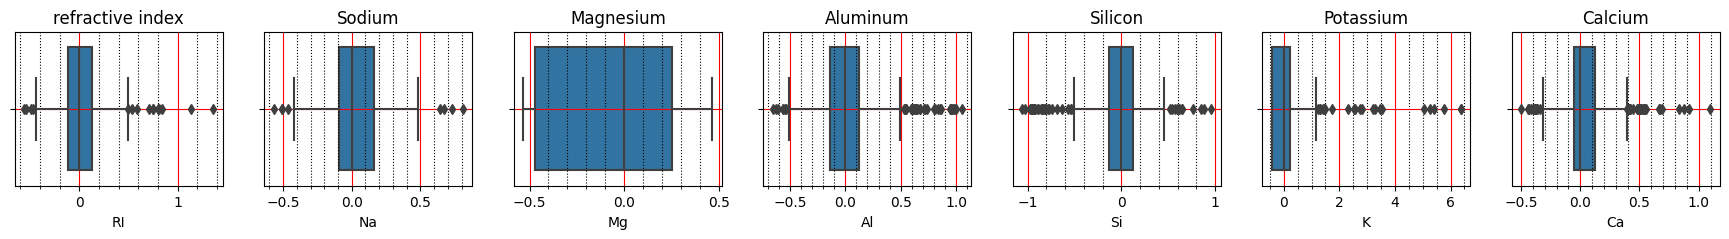

In [56]:
draw_plot(X_tmp,  num_features_dict, 'boxplot')

Выбросы остались во всех признаках, кроме Mg. Т.к. до нормального распределения K дотянуть не удалось, применение правила удаления выбросов 3 сигма для него будет некорректно 

## b) Исследуйте признаки на выбросы несколькими способами.

## c) Удалите выбросы. *Посчитайте процент удаленных записей от общего числа записей для каждого класса.

# 7. Повторите п. 4, п. 5.

Результ исследований - Датафрейм с колонками "способ поиска выбросов",  % выбросов,  Список индексов, "Classification_report"  
Будем искать выбросы,  выполнять обучение и тестирование модели в уже трансформированном датасете следующими способами: 


0.  [библиотека pyod](https://pyod.readthedocs.io/en/latest/) - 30 различных алгоримов, проверим  ECOD, IForest, OCSVM, LOF, KNN 
1. Правило 3 сигм
2. Межквартильный размах
3. Удаление выбросов с использованием процентилей
4. Махаланобис
5. One Class SVM
6. DBSCAN
7. KNN
8. Isolated Forest

### Вариант 0. библиотека pyod

 % Выбросов по ECOD: 5.263157894736842
Classification report ECOD

                                      precision    recall  f1-score   support

    building_windows_float_processed       0.82      0.53      0.64        17
building_windows_non_float_processed       0.93      0.78      0.85        18
     vehicle_windows_float_processed       1.00      0.89      0.94         9
                          containers       0.88      0.93      0.90        15
                           tableware       1.00      1.00      1.00        12
                           headlamps       0.64      1.00      0.78        16

                            accuracy                           0.84        87
                           macro avg       0.88      0.85      0.85        87
                        weighted avg       0.86      0.84      0.84        87




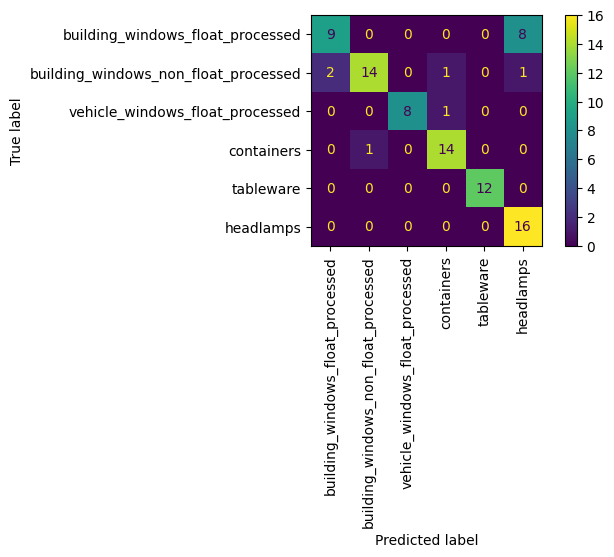

 % Выбросов по IForest: 5.482456140350877
Classification report IForest

                                      precision    recall  f1-score   support

    building_windows_float_processed       0.80      0.71      0.75        17
building_windows_non_float_processed       1.00      0.78      0.88        18
     vehicle_windows_float_processed       0.89      1.00      0.94         8
                          containers       1.00      1.00      1.00        18
                           tableware       1.00      1.00      1.00        10
                           headlamps       0.76      1.00      0.86        16

                            accuracy                           0.90        87
                           macro avg       0.91      0.91      0.91        87
                        weighted avg       0.91      0.90      0.90        87




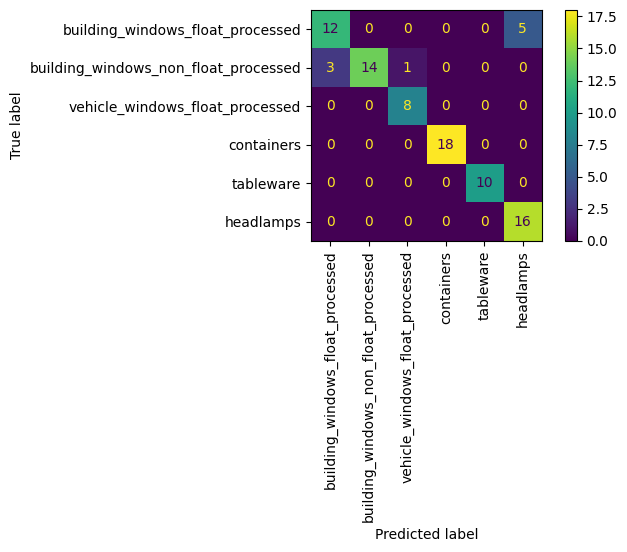

 % Выбросов по OCSVM: 5.263157894736842
Classification report OCSVM

                                      precision    recall  f1-score   support

    building_windows_float_processed       0.77      0.59      0.67        17
building_windows_non_float_processed       1.00      0.78      0.88        18
     vehicle_windows_float_processed       0.89      1.00      0.94         8
                          containers       0.93      0.93      0.93        15
                           tableware       1.00      1.00      1.00        12
                           headlamps       0.71      1.00      0.83        17

                            accuracy                           0.86        87
                           macro avg       0.88      0.88      0.87        87
                        weighted avg       0.88      0.86      0.86        87




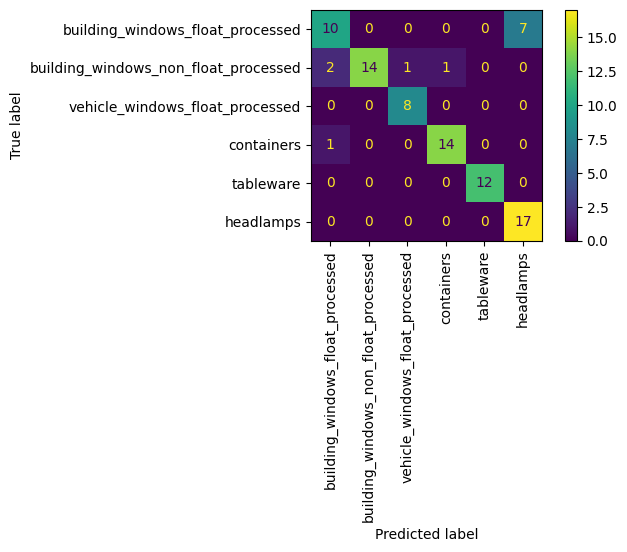

 % Выбросов по LOF: 5.482456140350877
Classification report LOF

                                      precision    recall  f1-score   support

    building_windows_float_processed       0.77      0.56      0.65        18
building_windows_non_float_processed       1.00      0.83      0.91        18
     vehicle_windows_float_processed       1.00      1.00      1.00         7
                          containers       1.00      1.00      1.00        18
                           tableware       1.00      1.00      1.00        10
                           headlamps       0.67      1.00      0.80        16

                            accuracy                           0.87        87
                           macro avg       0.91      0.90      0.89        87
                        weighted avg       0.89      0.87      0.87        87




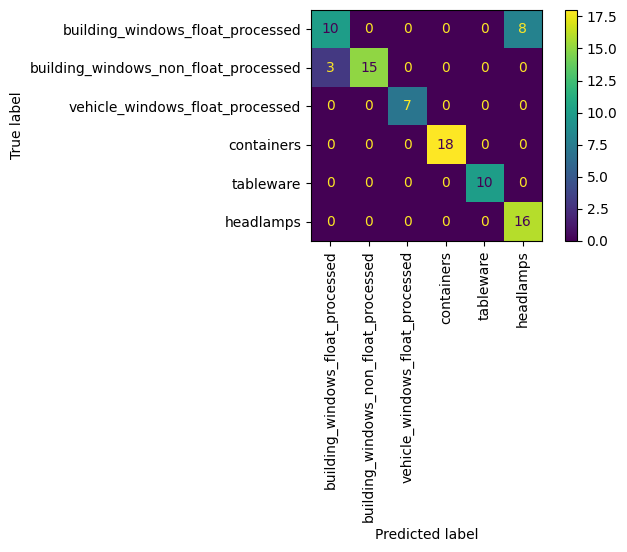

 % Выбросов по KNN: 5.263157894736842
Classification report KNN

                                      precision    recall  f1-score   support

    building_windows_float_processed       0.60      0.38      0.46        16
building_windows_non_float_processed       1.00      0.78      0.88        18
     vehicle_windows_float_processed       1.00      1.00      1.00         8
                          containers       1.00      1.00      1.00        16
                           tableware       1.00      1.00      1.00        12
                           headlamps       0.59      0.94      0.73        17

                            accuracy                           0.83        87
                           macro avg       0.87      0.85      0.84        87
                        weighted avg       0.85      0.83      0.82        87




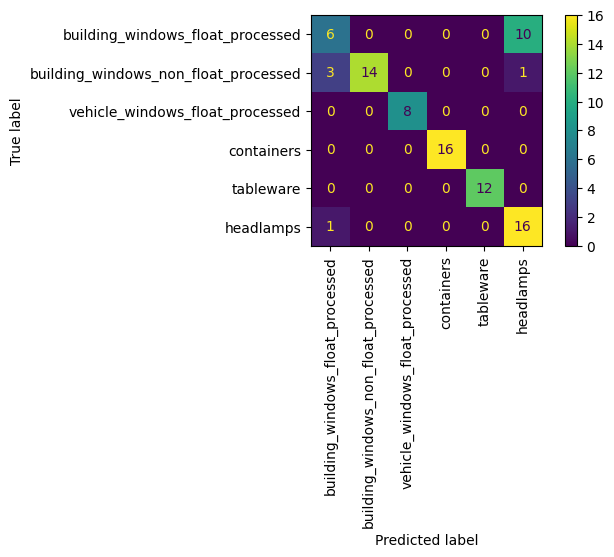

In [57]:
contamination = 0.06  # выбросы 6%
outline_removers = []
outliners_list=[]
outline_removers.append(('ECOD', ECOD(contamination=contamination)))
outline_removers.append(('IForest', IForest(contamination=contamination)))
outline_removers.append(('OCSVM', OCSVM(contamination=contamination)))
outline_removers.append(('LOF', LOF(contamination=contamination)))
outline_removers.append(('KNN', KNN(contamination=contamination)))

for name, model in outline_removers:
  indices_train, indices_test = [], []
  clf = model
  clf.fit(X_train)
  y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
  y_train_scores = clf.decision_scores_  # raw outlier scores
  y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
  y_test_scores = clf.decision_function(X_test)  # outlier scores

  # Получаем долю выбросов и их индексы
  indices_train = [i for i in range(0, len(y_train_pred)) if y_train_pred[i]==1]   # Это выбросы на обучающей выборке
  indices_test = [i for i in range(0, len(y_test_pred)) if y_test_pred[i]==1]   # это выбросы на тестовой выборке
  indices = set(indices_train).union(set(indices_test)) 
  share = len(indices)/len(X)*100
  print(f' % Выбросов по {name}: {share}')

  dict_outliners = dict()
  indices_outliners = dict()
  outliners=data.loc[list(indices)]
  for key, value in class_labels.items():
    dict_outliners[value] = outliners[outliners['target']==value].shape[0]/data.shape[0]*100
    indices_outliners[value] = outliners[outliners['target']==value].index.to_list()
  


  # Удаляем выбросы и пересчитываем модель
  tmp=data.drop(index= list(indices))
  method,  report, a = get_learn(tmp,random_seed, name, RandomForestClassifier(criterion='entropy',random_state=random_seed), flag=True )

  # Фиксируем результаты
  df_results.loc[len(df_results.index)] = [method, share, indices, a]

  for key, value in class_labels.items():
    report_ = report[value]
    exper.loc[len(exper.index)] = [method, value,  report_['precision'], report_['recall'], report_['f1-score'], dict_outliners[value], indices_outliners[value] ]

In [58]:
df_results.sort_values(by=['accuracy'], ascending=False).style.format() \
 .highlight_null(null_color='lightgrey') \
 .highlight_max(color='yellowgreen', subset=['share', 'accuracy']) \
 .highlight_min(color='coral', subset=['share', 'accuracy']) 


,method,share,indices,accuracy
1,CombineTransformer,0.000000,set(),0.945652
2,adjdatatools,0.000000,set(),0.945652
4,IForest,5.482456,"{196, 324, 325, 6, 9, 137, 77, 207, 84, 21, 219, 284, 158, 97, 291, 36, 359, 360, 106, 299, 108, 236, 42, 50, 123}",0.896552
6,LOF,5.482456,"{64, 257, 194, 67, 196, 5, 325, 9, 137, 274, 84, 344, 284, 93, 158, 97, 36, 357, 359, 106, 42, 174, 244, 53, 251}",0.873563
5,OCSVM,5.263158,"{196, 6, 9, 77, 219, 284, 158, 161, 97, 291, 36, 38, 359, 360, 106, 299, 108, 236, 174, 42, 50, 115, 312, 123}",0.862069
3,ECOD,5.263158,"{196, 6, 9, 77, 219, 93, 158, 161, 97, 291, 36, 38, 359, 360, 106, 299, 108, 236, 174, 42, 50, 115, 312, 123}",0.839080
7,KNN,5.263158,"{196, 325, 6, 9, 137, 77, 274, 84, 284, 93, 158, 97, 291, 36, 357, 359, 106, 299, 236, 174, 244, 53, 251, 63}",0.827586
0,baseline,0.000000,set(),0.813953


Из рассмотренных алгоритмов поиска выбросов лучщие результаты показал IForest. Удаление выбросов позволит повысить Accuracy в целом ( с 0.81 до 0.897). В некоторых классах, однако, понижается Precision и recall по сравнению с базовой моделью. 

### Вариант 1. Правило 3 сигма - для RI,	Na,	Al,	Si,	Ca

% выбросов по правилу 3sigma: 5.0438596491228065 
Classification report 3sigma

                                      precision    recall  f1-score   support

    building_windows_float_processed       0.88      0.78      0.82        18
building_windows_non_float_processed       0.93      0.82      0.87        17
     vehicle_windows_float_processed       1.00      1.00      1.00         6
                          containers       1.00      1.00      1.00        16
                           tableware       0.92      1.00      0.96        12
                           headlamps       0.81      0.94      0.87        18

                            accuracy                           0.91        87
                           macro avg       0.92      0.92      0.92        87
                        weighted avg       0.91      0.91      0.91        87




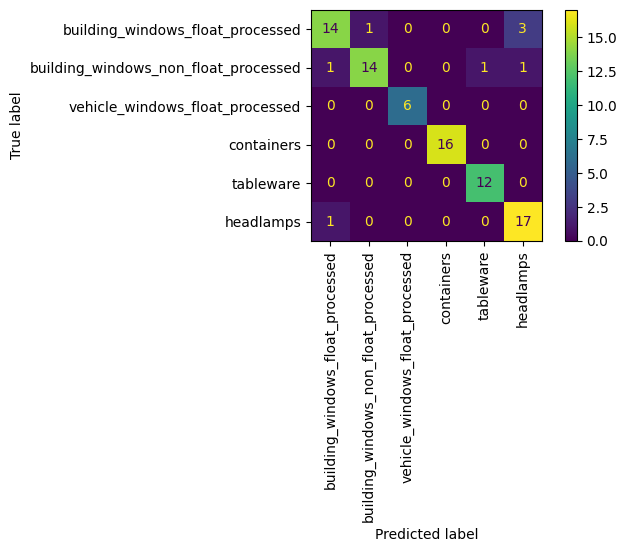

In [59]:
tmp=data.copy()
names=['RI', 'Na', 'Al', 'Si', 'Ca']
method = '3sigma'

# Получаем долю выбросов и их индексы
share, indices = sigma_3(tmp,names, 10)
print(f'% выбросов по правилу {method}: {share} ')

# Удаляем выбросы и пересчитываем модель
tmp=data.drop(index= list(indices))
method,  report, a = get_learn(tmp,random_seed, method, RandomForestClassifier(criterion='entropy',random_state=random_seed), flag=True )

# Фиксируем результаты
df_results.loc[len(df_results.index)] = [method, share, indices, a]

dict_outliners = dict()
indices_outliners = dict()
outliners=data.loc[list(indices)]

for key, value in class_labels.items():
  dict_outliners[value] = outliners[outliners['target']==value].shape[0]/data.shape[0]*100
  indices_outliners[value] = outliners[outliners['target']==value].index.to_list()
  report_ = report[value]
  exper.loc[len(exper.index)] = [method, key,  report_['precision'], report_['recall'], report_['f1-score'], dict_outliners[value], indices_outliners[value] ]


In [60]:
df_results.sort_values(by=['accuracy'], ascending=False).style.format() \
 .highlight_null(null_color='lightgrey') \
 .highlight_max(color='yellowgreen', subset=['share', 'accuracy']) \
 .highlight_min(color='coral', subset=['share', 'accuracy']) 

,method,share,indices,accuracy
1,CombineTransformer,0.000000,set(),0.945652
2,adjdatatools,0.000000,set(),0.945652
8,3sigma,5.043860,"{131, 261, 265, 201, 270, 273, 349, 225, 163, 228, 357, 166, 103, 360, 106, 107, 110, 47, 111, 112, 240, 245, 184}",0.908046
4,IForest,5.482456,"{196, 324, 325, 6, 9, 137, 77, 207, 84, 21, 219, 284, 158, 97, 291, 36, 359, 360, 106, 299, 108, 236, 42, 50, 123}",0.896552
6,LOF,5.482456,"{64, 257, 194, 67, 196, 5, 325, 9, 137, 274, 84, 344, 284, 93, 158, 97, 36, 357, 359, 106, 42, 174, 244, 53, 251}",0.873563
5,OCSVM,5.263158,"{196, 6, 9, 77, 219, 284, 158, 161, 97, 291, 36, 38, 359, 360, 106, 299, 108, 236, 174, 42, 50, 115, 312, 123}",0.862069
3,ECOD,5.263158,"{196, 6, 9, 77, 219, 93, 158, 161, 97, 291, 36, 38, 359, 360, 106, 299, 108, 236, 174, 42, 50, 115, 312, 123}",0.839080
7,KNN,5.263158,"{196, 325, 6, 9, 137, 77, 274, 84, 284, 93, 158, 97, 291, 36, 357, 359, 106, 299, 236, 174, 244, 53, 251, 63}",0.827586
0,baseline,0.000000,set(),0.813953


После удаления выбросов по 3 сигма accuracy модели возросла до 0.91 ( по сравнению с 0.81 в базовой модели). Более равномерно распределены precision и recall среди классов

### Вариант 2. Межквартильный размах https://habr.com/ru/articles/527334/ для для RI Na Al Si Ca и K

In [61]:
tmp=data.copy()
names=['RI', 'Na', 'Al', 'Si', 'Ca']
method = 'quantile range'

# Получаем долю выбросов и их индексы
share, indices = interquartile_range(tmp,names, 10)
print(f'% выбросов по правилу {method}: {share} ')
if share <= percent:
  # Удаляем выбросы и пересчитываем модель
  tmp=data.drop(index= list(indices))
  method,  report, a = get_learn(tmp,random_seed, method, RandomForestClassifier(criterion='entropy',random_state=random_seed), flag=True )

  # Фиксируем результаты
  df_results.loc[len(df_results.index)] = [method, share, indices, a]

  dict_outliners = dict()
  indices_outliners = dict()
  outliners=data.loc[list(indices)]

  for key, value in class_labels.items():
    dict_outliners[value] = outliners[outliners['target']==value].shape[0]/data.shape[0]*100
    indices_outliners[value] = outliners[outliners['target']==value].index.to_list()
    report_ = report[value]
    exper.loc[len(exper.index)] = [method,  value,  report_['precision'], report_['recall'], report_['f1-score'], dict_outliners[value], indices_outliners[value] ]


% выбросов по правилу quantile range: 20.394736842105264 


In [62]:
df_results.sort_values(by=['accuracy'], ascending=False).style.format() \
 .highlight_null(null_color='lightgrey') \
 .highlight_max(color='yellowgreen', subset=['share', 'accuracy']) \
 .highlight_min(color='coral', subset=['share', 'accuracy']) 

,method,share,indices,accuracy
1,CombineTransformer,0.000000,set(),0.945652
2,adjdatatools,0.000000,set(),0.945652
8,3sigma,5.043860,"{131, 261, 265, 201, 270, 273, 349, 225, 163, 228, 357, 166, 103, 360, 106, 107, 110, 47, 111, 112, 240, 245, 184}",0.908046
4,IForest,5.482456,"{196, 324, 325, 6, 9, 137, 77, 207, 84, 21, 219, 284, 158, 97, 291, 36, 359, 360, 106, 299, 108, 236, 42, 50, 123}",0.896552
6,LOF,5.482456,"{64, 257, 194, 67, 196, 5, 325, 9, 137, 274, 84, 344, 284, 93, 158, 97, 36, 357, 359, 106, 42, 174, 244, 53, 251}",0.873563
5,OCSVM,5.263158,"{196, 6, 9, 77, 219, 284, 158, 161, 97, 291, 36, 38, 359, 360, 106, 299, 108, 236, 174, 42, 50, 115, 312, 123}",0.862069
3,ECOD,5.263158,"{196, 6, 9, 77, 219, 93, 158, 161, 97, 291, 36, 38, 359, 360, 106, 299, 108, 236, 174, 42, 50, 115, 312, 123}",0.839080
7,KNN,5.263158,"{196, 325, 6, 9, 137, 77, 274, 84, 284, 93, 158, 97, 291, 36, 357, 359, 106, 299, 236, 174, 244, 53, 251, 63}",0.827586
0,baseline,0.000000,set(),0.813953


Этот метод рассчитал слишком большой % выбросов. Удаление выбросов по методу межквартильного размаха ухудшило метрики качества, в датафрейм результатов не добавляем. 

### Вариант 3. Удаление выбросов с использованием процентилей

% выбросов по правилу percentile range: 3.7280701754385963 
Classification report percentile range

                                      precision    recall  f1-score   support

    building_windows_float_processed       0.83      0.83      0.83        18
building_windows_non_float_processed       1.00      0.80      0.89        20
     vehicle_windows_float_processed       0.82      1.00      0.90         9
                          containers       1.00      0.94      0.97        16
                           tableware       1.00      1.00      1.00         8
                           headlamps       0.85      1.00      0.92        17

                            accuracy                           0.91        88
                           macro avg       0.92      0.93      0.92        88
                        weighted avg       0.92      0.91      0.91        88




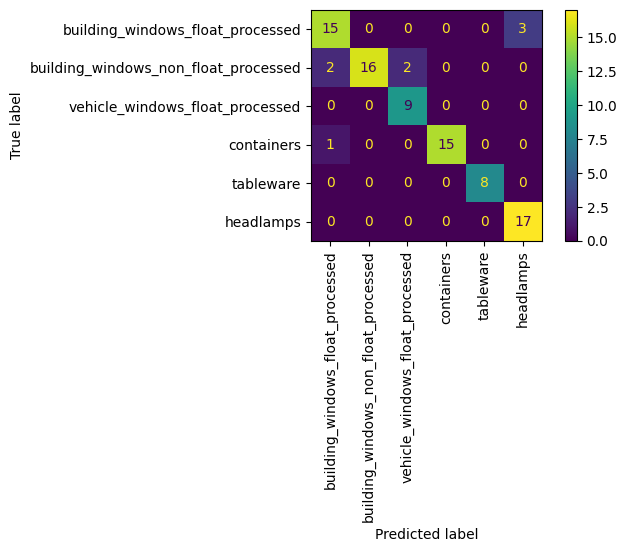

In [63]:
tmp=data.copy()
names=['RI', 'Na', 'Al', 'Si', 'Ca']
method = 'percentile range'

# Получаем долю выбросов и их индексы
share, indices = percentile_range(tmp,names, 10)
print(f'% выбросов по правилу {method}: {share} ')
if share <= percent:
  # Удаляем выбросы и пересчитываем модель
  tmp=data.drop(index= list(indices))
  method,  report, a = get_learn(tmp,random_seed, method, RandomForestClassifier(criterion='entropy',random_state=random_seed), flag=True )

  # Фиксируем результаты
  df_results.loc[len(df_results.index)] = [method, share, indices, a]

  dict_outliners = dict()
  indices_outliners = dict()
  outliners=data.loc[list(indices)]

  for key, value in class_labels.items():
    dict_outliners[value] = outliners[outliners['target']==value].shape[0]/data.shape[0]*100
    indices_outliners[value] = outliners[outliners['target']==value].index.to_list()
    report_ = report[value]
    exper.loc[len(exper.index)] = [method,  value,  report_['precision'], report_['recall'], report_['f1-score'], dict_outliners[value], indices_outliners[value] ]

In [64]:
df_results.sort_values(by=['accuracy'], ascending=False).style.format() \
 .highlight_null(null_color='lightgrey') \
 .highlight_max(color='yellowgreen', subset=['share', 'accuracy']) \
 .highlight_min(color='coral', subset=['share', 'accuracy']) 

,method,share,indices,accuracy
1,CombineTransformer,0.000000,set(),0.945652
2,adjdatatools,0.000000,set(),0.945652
9,percentile range,3.728070,"{163, 217, 357, 166, 201, 106, 107, 110, 111, 112, 240, 273, 21, 184, 185, 186, 349}",0.909091
8,3sigma,5.043860,"{131, 261, 265, 201, 270, 273, 349, 225, 163, 228, 357, 166, 103, 360, 106, 107, 110, 47, 111, 112, 240, 245, 184}",0.908046
4,IForest,5.482456,"{196, 324, 325, 6, 9, 137, 77, 207, 84, 21, 219, 284, 158, 97, 291, 36, 359, 360, 106, 299, 108, 236, 42, 50, 123}",0.896552
6,LOF,5.482456,"{64, 257, 194, 67, 196, 5, 325, 9, 137, 274, 84, 344, 284, 93, 158, 97, 36, 357, 359, 106, 42, 174, 244, 53, 251}",0.873563
5,OCSVM,5.263158,"{196, 6, 9, 77, 219, 284, 158, 161, 97, 291, 36, 38, 359, 360, 106, 299, 108, 236, 174, 42, 50, 115, 312, 123}",0.862069
3,ECOD,5.263158,"{196, 6, 9, 77, 219, 93, 158, 161, 97, 291, 36, 38, 359, 360, 106, 299, 108, 236, 174, 42, 50, 115, 312, 123}",0.839080
7,KNN,5.263158,"{196, 325, 6, 9, 137, 77, 274, 84, 284, 93, 158, 97, 291, 36, 357, 359, 106, 299, 236, 174, 244, 53, 251, 63}",0.827586
0,baseline,0.000000,set(),0.813953


Качество модели выросло по сравнению с базовой и обогнало 3 сигма

### Вариант 4. Старый добрый вариант по расстоянию Махаланобиса 

% выбросов по правилу mahalonobis: 6.140350877192982 
Classification report mahalonobis

                                      precision    recall  f1-score   support

    building_windows_float_processed       0.79      0.69      0.73        16
building_windows_non_float_processed       0.81      0.76      0.79        17
     vehicle_windows_float_processed       0.86      1.00      0.92         6
                          containers       1.00      0.94      0.97        17
                           tableware       0.88      1.00      0.93         7
                           headlamps       0.84      0.91      0.87        23

                            accuracy                           0.86        86
                           macro avg       0.86      0.88      0.87        86
                        weighted avg       0.86      0.86      0.86        86




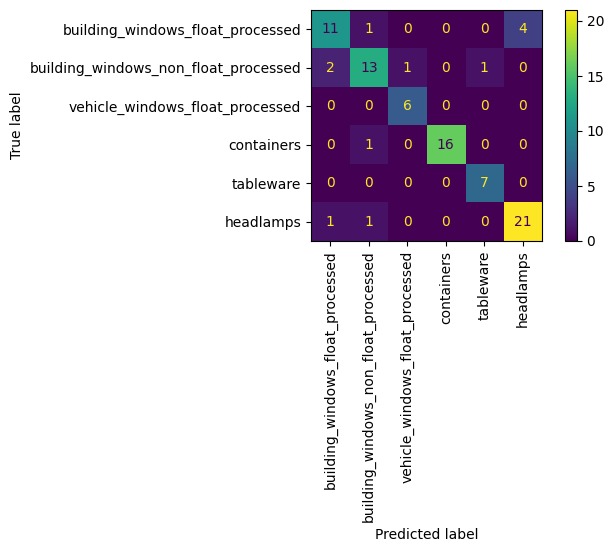

In [65]:
tmp=data.copy()
method =  'mahalonobis'
start_len= len(tmp)
X_tmp=tmp.drop(columns=['target'])
y_tmp=tmp['target']
tmp['mahalanobis'] = mahalanobis(x=X_tmp, data=X_tmp[list(X_tmp.columns)])
tmp['p'] = 1 - chi2.cdf(tmp['mahalanobis'], len(list(X_tmp.columns))-1)

# Удаляем выбросы , сохраняем их индексы (Обычно выбросом считается p-значение меньше 0,001)

indices = set(tmp[tmp['p']<=0.001].index.to_list())
tmp = tmp[tmp['p']>0.001]
share = (start_len-len(tmp))/start_len*100
print(f'% выбросов по правилу mahalonobis: {share} ')

if share < percent:
  # Пересчитываем модель
  method,  report, a = get_learn(tmp,random_seed, method, RandomForestClassifier(criterion='entropy',random_state=random_seed), flag=True )

  # Фиксируем результаты
  df_results.loc[len(df_results.index)] = [method, share, indices, a]

  dict_outliners = dict()
  indices_outliners = dict()
  outliners=data.loc[list(indices)]

  for key, value in class_labels.items():
    dict_outliners[value] = outliners[outliners['target']==value].shape[0]/data.shape[0]*100
    indices_outliners[value] = outliners[outliners['target']==value].index.to_list()
    report_ = report[value]
    exper.loc[len(exper.index)] = [method,  value,  report_['precision'], report_['recall'], report_['f1-score'], dict_outliners[value], indices_outliners[value] ]

In [66]:
df_results.sort_values(by=['accuracy'], ascending=False).style.format() \
 .highlight_null(null_color='lightgrey') \
 .highlight_max(color='yellowgreen', subset=['share', 'accuracy']) \
 .highlight_min(color='coral', subset=['share', 'accuracy']) 

,method,share,indices,accuracy
1,CombineTransformer,0.000000,set(),0.945652
2,adjdatatools,0.000000,set(),0.945652
9,percentile range,3.728070,"{163, 217, 357, 166, 201, 106, 107, 110, 111, 112, 240, 273, 21, 184, 185, 186, 349}",0.909091
8,3sigma,5.043860,"{131, 261, 265, 201, 270, 273, 349, 225, 163, 228, 357, 166, 103, 360, 106, 107, 110, 47, 111, 112, 240, 245, 184}",0.908046
4,IForest,5.482456,"{196, 324, 325, 6, 9, 137, 77, 207, 84, 21, 219, 284, 158, 97, 291, 36, 359, 360, 106, 299, 108, 236, 42, 50, 123}",0.896552
6,LOF,5.482456,"{64, 257, 194, 67, 196, 5, 325, 9, 137, 274, 84, 344, 284, 93, 158, 97, 36, 357, 359, 106, 42, 174, 244, 53, 251}",0.873563
5,OCSVM,5.263158,"{196, 6, 9, 77, 219, 284, 158, 161, 97, 291, 36, 38, 359, 360, 106, 299, 108, 236, 174, 42, 50, 115, 312, 123}",0.862069
10,mahalonobis,6.140351,"{263, 269, 273, 281, 163, 36, 298, 171, 172, 47, 56, 184, 316, 189, 327, 201, 207, 349, 225, 228, 357, 231, 360, 106, 107, 111, 240, 250}",0.860465
3,ECOD,5.263158,"{196, 6, 9, 77, 219, 93, 158, 161, 97, 291, 36, 38, 359, 360, 106, 299, 108, 236, 174, 42, 50, 115, 312, 123}",0.839080
7,KNN,5.263158,"{196, 325, 6, 9, 137, 77, 274, 84, 284, 93, 158, 97, 291, 36, 357, 359, 106, 299, 236, 174, 244, 53, 251, 63}",0.827586


### Вариант 5. Метод опорных векторов 

% выбросов по OCSVM sclearn rbf 0.08: 8.644859813084112 , a= 0.9404761904761905
Classification report OCSVM sclearn rbf 0.08

                                      precision    recall  f1-score   support

    building_windows_float_processed       1.00      0.94      0.97        17
building_windows_non_float_processed       0.93      0.76      0.84        17
     vehicle_windows_float_processed       1.00      1.00      1.00         8
                          containers       0.94      1.00      0.97        16
                           tableware       1.00      1.00      1.00         9
                           headlamps       0.85      1.00      0.92        17

                            accuracy                           0.94        84
                           macro avg       0.95      0.95      0.95        84
                        weighted avg       0.94      0.94      0.94        84




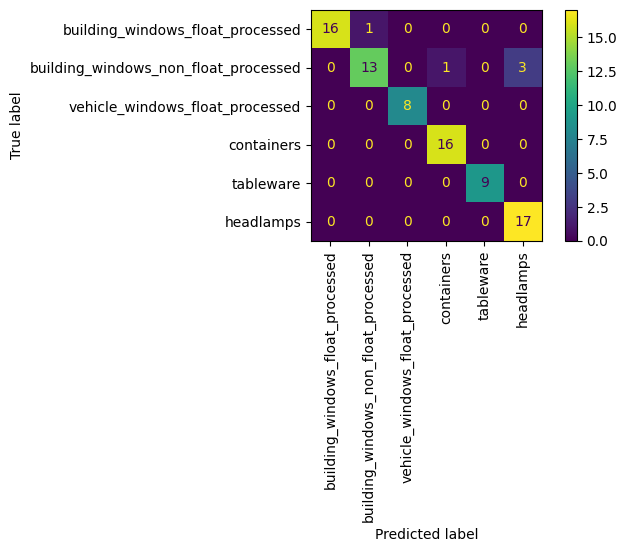

In [67]:
tmp=data.copy()
X=tmp.drop(columns=['target'])
y=tmp['target']

kernels = {'linear', 'poly', 'rbf', 'sigmoid'} 
nus=[0.04, 0.06,0.08,0.1,0.2,0.3,0.4]
indices=[]
a_base = 0.9
for kernel in kernels:
  for nu in nus:
    method = f'OCSVM sclearn {kernel} {nu}'
    clf = OneClassSVM(kernel=kernel, nu=nu).fit(X)
    arr = clf.predict(X)
    unique, counts = np.unique(arr, return_counts=True)
    result = np.column_stack((unique, counts))

    # Получаем долю выбросов и их индексы
    share = result[0][1]/tmp.shape[0]*100 # доля выбросов
    if share <= percent:
        # print(f'% выбросов по {method}: {share} ')
              
        if ((result[0][1] >=int(tmp.shape[0]*0.01)) & (result[0][1] <int(tmp.shape[0]*0.10))): # к-во строк с выбросами
            
          indices = [i for i in range(0, len(arr)) if arr[i]==-1] 

          # Удаляем выбросы и пересчитываем модель
          tmp = data.drop(index= list(indices))
          method,  report, a = get_learn(tmp,random_seed, method, RandomForestClassifier(criterion='entropy',random_state=random_seed), flag=False )
          # print(f'% выбросов по {method} {kernel} nu={nu}: {share} , a= {a}') 
          if a >= a_base:
            opt_method = method
            opt_kernel=kernelopt_nu=nu
            opt_nu=nu
            opt_share = share
            opt_indices = indices
            opt_a = a
            opt_report = report
            a_base = a

            dict_outliners = dict()
            indices_outliners = dict()
            outliners=data.loc[list(indices)]

            for key, value in class_labels.items():
              dict_outliners[value] = outliners[outliners['target']==value].shape[0]/data.shape[0]*100
              indices_outliners[value] = outliners[outliners['target']==value].index.to_list()
              # report_ = report[value]
              # exper.loc[len(exper.index)] = [method, key,  report_['precision'], report_['recall'], report_['f1-score'], dict_outliners[value], indices_outliners[value] ]

#  Фиксируем результаты
df_results.loc[len(df_results.index)] = [opt_method, opt_share, opt_indices, opt_a]
for key, value in class_labels.items():
  dict_outliners[value] = outliners[outliners['target']==value].shape[0]/data.shape[0]*100
  indices_outliners[value] = outliners[outliners['target']==value].index.to_list()
  report_ = opt_report[value]
  exper.loc[len(exper.index)] = [method,  value,  report_['precision'], report_['recall'], report_['f1-score'], dict_outliners[value], indices_outliners[value] ]
print(f'% выбросов по {opt_method}: {opt_share} , a= {opt_a}') 
tmp = data.drop(index= list(opt_indices))
method,  report, a = get_learn(tmp,random_seed, opt_method, RandomForestClassifier(criterion='entropy',random_state=random_seed), flag=True )

In [68]:
df_results.sort_values(by=['accuracy'], ascending=False).style.format() \
 .highlight_null(null_color='lightgrey') \
 .highlight_max(color='yellowgreen', subset=['share', 'accuracy']) \
 .highlight_min(color='coral', subset=['share', 'accuracy']) 

,method,share,indices,accuracy
1,CombineTransformer,0.000000,set(),0.945652
2,adjdatatools,0.000000,set(),0.945652
11,OCSVM sclearn rbf 0.08,8.644860,"[0, 70, 103, 105, 106, 107, 109, 110, 111, 112, 131, 163, 166, 171, 172, 173, 184, 185, 186, 201, 220, 225, 228, 231, 240, 245, 247, 250, 261, 263, 265, 270, 273, 281, 349, 357, 360]",0.940476
9,percentile range,3.728070,"{163, 217, 357, 166, 201, 106, 107, 110, 111, 112, 240, 273, 21, 184, 185, 186, 349}",0.909091
8,3sigma,5.043860,"{131, 261, 265, 201, 270, 273, 349, 225, 163, 228, 357, 166, 103, 360, 106, 107, 110, 47, 111, 112, 240, 245, 184}",0.908046
4,IForest,5.482456,"{196, 324, 325, 6, 9, 137, 77, 207, 84, 21, 219, 284, 158, 97, 291, 36, 359, 360, 106, 299, 108, 236, 42, 50, 123}",0.896552
6,LOF,5.482456,"{64, 257, 194, 67, 196, 5, 325, 9, 137, 274, 84, 344, 284, 93, 158, 97, 36, 357, 359, 106, 42, 174, 244, 53, 251}",0.873563
5,OCSVM,5.263158,"{196, 6, 9, 77, 219, 284, 158, 161, 97, 291, 36, 38, 359, 360, 106, 299, 108, 236, 174, 42, 50, 115, 312, 123}",0.862069
10,mahalonobis,6.140351,"{263, 269, 273, 281, 163, 36, 298, 171, 172, 47, 56, 184, 316, 189, 327, 201, 207, 349, 225, 228, 357, 231, 360, 106, 107, 111, 240, 250}",0.860465
3,ECOD,5.263158,"{196, 6, 9, 77, 219, 93, 158, 161, 97, 291, 36, 38, 359, 360, 106, 299, 108, 236, 174, 42, 50, 115, 312, 123}",0.839080


### Вариант 6.  DBSCAN

% выбросов по DBSCAN  r=2.0 sample=5 : 1.55902004454343 , a= 0.9333333333333333
Classification report DBSCAN  r=2.0 sample=5

                                      precision    recall  f1-score   support

    building_windows_float_processed       0.83      0.88      0.86        17
building_windows_non_float_processed       1.00      0.89      0.94        18
     vehicle_windows_float_processed       1.00      0.90      0.95        10
                          containers       0.94      1.00      0.97        16
                           tableware       1.00      1.00      1.00        14
                           headlamps       0.88      0.93      0.90        15

                            accuracy                           0.93        90
                           macro avg       0.94      0.93      0.94        90
                        weighted avg       0.94      0.93      0.93        90




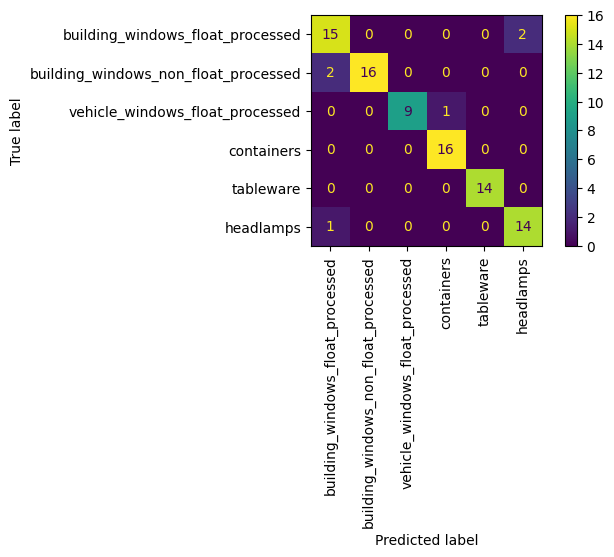

In [69]:
tmp = data.copy()
X = tmp.drop(columns=['target'])
y = tmp['target']
a_base = 0.92
rads = np.array([3., 2., 1., 0.5]) # Максимальные расстояния между двумя образцами, при котором один считается соседом другого
samples = [i for i in range(2,6)] # Количество выборок (или общий вес) в окрестности точки, которую следует рассматривать как основную точку. В том числе и сама точка

for r in rads:

  for sample in samples:

    clustering = DBSCAN(eps=r, min_samples=sample).fit(X)
    unique, counts = np.unique(clustering.labels_, return_counts=True)
    result = np.column_stack((unique, counts))
    
    # Получаем долю выбросов и их индексы
    share = result[0][1]/tmp.shape[0]*100 # доля выбросов
    if share <= percent:
      if ((result[0][1] >=int(tmp.shape[0]*0.01)) & (result[0][1] <int(tmp.shape[0]*0.10))): #к-во строк с выбросами
        method = f'DBSCAN  r={r} sample={sample}'
        # print(f'% выбросов по {method}: {share} ')
        indices = [i for i in range(0, len(clustering.labels_)) if clustering.labels_[i]==-1] 
        
        # Удаляем выбросы и пересчитываем модель
        tmp = data.drop(index= list(indices))
        method,  report, a = get_learn(tmp,random_seed, method, RandomForestClassifier(criterion='entropy',random_state=random_seed), flag=False )

        if (a >= a_base) :
          opt_method = method
          opt_r = r
          opt_sample = sample
          opt_share = share
          opt_indices = indices
          opt_a = a
          opt_report = report
          a_base = a

          dict_outliners = dict()
          indices_outliners = dict()
          outliners=data.loc[list(indices)]

          for key, value in class_labels.items():
            dict_outliners[value] = outliners[outliners['target']==value].shape[0]/data.shape[0]*100
            indices_outliners[value] = outliners[outliners['target']==value].index.to_list()

# Фиксируем результаты
df_results.loc[len(df_results.index)] = [opt_method, opt_share, opt_indices, opt_a]

for key, value in class_labels.items():
  dict_outliners[value] = outliners[outliners['target']==value].shape[0]/data.shape[0]*100
  indices_outliners[value] = outliners[outliners['target']==value].index.to_list()
  report_ = opt_report[value]
  exper.loc[len(exper.index)] = [method,  value,  report_['precision'], report_['recall'], report_['f1-score'], dict_outliners[value], indices_outliners[value] ]
print(f'% выбросов по {opt_method} : {opt_share} , a= {opt_a}')  
tmp = data.drop(index= list(opt_indices))
method,  report, a = get_learn(tmp,random_seed, opt_method, RandomForestClassifier(criterion='entropy',random_state=random_seed), flag=True )  

In [70]:
df_results.sort_values(by=['accuracy'], ascending=False).style.format() \
 .highlight_null(null_color='lightgrey') \
 .highlight_max(color='yellowgreen', subset=['share', 'accuracy']) \
 .highlight_min(color='coral', subset=['share', 'accuracy'])

,method,share,indices,accuracy
1,CombineTransformer,0.000000,set(),0.945652
2,adjdatatools,0.000000,set(),0.945652
11,OCSVM sclearn rbf 0.08,8.644860,"[0, 70, 103, 105, 106, 107, 109, 110, 111, 112, 131, 163, 166, 171, 172, 173, 184, 185, 186, 201, 220, 225, 228, 231, 240, 245, 247, 250, 261, 263, 265, 270, 273, 281, 349, 357, 360]",0.940476
12,DBSCAN r=2.0 sample=5,1.559020,"[105, 106, 107, 110, 111, 112, 298]",0.933333
9,percentile range,3.728070,"{163, 217, 357, 166, 201, 106, 107, 110, 111, 112, 240, 273, 21, 184, 185, 186, 349}",0.909091
8,3sigma,5.043860,"{131, 261, 265, 201, 270, 273, 349, 225, 163, 228, 357, 166, 103, 360, 106, 107, 110, 47, 111, 112, 240, 245, 184}",0.908046
4,IForest,5.482456,"{196, 324, 325, 6, 9, 137, 77, 207, 84, 21, 219, 284, 158, 97, 291, 36, 359, 360, 106, 299, 108, 236, 42, 50, 123}",0.896552
6,LOF,5.482456,"{64, 257, 194, 67, 196, 5, 325, 9, 137, 274, 84, 344, 284, 93, 158, 97, 36, 357, 359, 106, 42, 174, 244, 53, 251}",0.873563
5,OCSVM,5.263158,"{196, 6, 9, 77, 219, 284, 158, 161, 97, 291, 36, 38, 359, 360, 106, 299, 108, 236, 174, 42, 50, 115, 312, 123}",0.862069
10,mahalonobis,6.140351,"{263, 269, 273, 281, 163, 36, 298, 171, 172, 47, 56, 184, 316, 189, 327, 201, 207, 349, 225, 228, 357, 231, 360, 106, 107, 111, 240, 250}",0.860465


### Вариант 7. KNN (sklearn)

% выбросов по KNN_sklearn th=0.95 : 7.675438596491229 , a= 0.9176470588235294
Classification report KNN_sklearn th=0.95

                                      precision    recall  f1-score   support

    building_windows_float_processed       0.88      0.79      0.83        19
building_windows_non_float_processed       0.93      0.81      0.87        16
     vehicle_windows_float_processed       1.00      1.00      1.00         8
                          containers       1.00      1.00      1.00        15
                           tableware       1.00      1.00      1.00         8
                           headlamps       0.83      1.00      0.90        19

                            accuracy                           0.92        85
                           macro avg       0.94      0.93      0.93        85
                        weighted avg       0.92      0.92      0.92        85




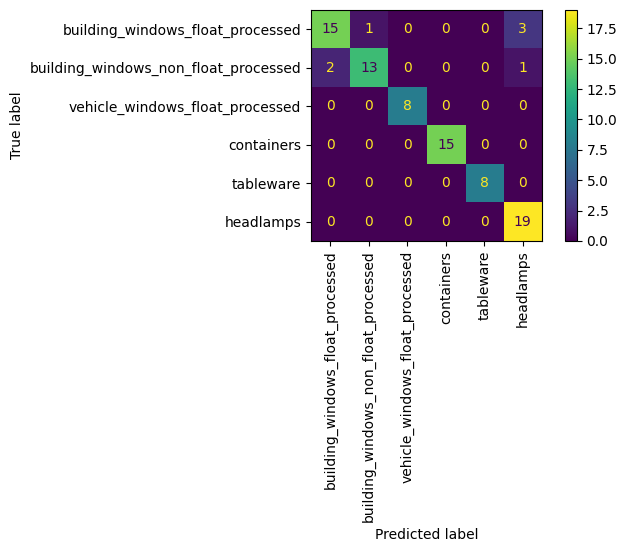

In [71]:
ths = [0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.2, 1.3, 1.5] # Это порог, до которого точки - соседи
a_base = 0.91 # ищем варианты порога, чтобы accuracy была выше a_base
for th in ths:
  tmp=data.copy()
  X=tmp.drop(columns=['target'])
  y=tmp['target']
  method = f'KNN_sklearn th={th}'

  start_len=tmp.shape[0]
  clf = KNeighborsClassifier(n_neighbors=5)
  clf.fit(X, y)
  distances, indexes = clf.kneighbors(X)
  distances = pd.DataFrame(distances)
  distances_mean = distances.mean(axis =1)
 
  # Получаем  индексы выбросов
  indices = np.where(distances_mean > th)[0]

  # Удаляем выбросы и пересчитываем модель, находим долю
  tmp = data.drop(index= list(indices))
  share = (start_len-tmp.shape[0])/start_len*100

  if share<=10: 

    method, report, a = get_learn(tmp,random_seed, method, RandomForestClassifier(criterion='entropy',random_state=random_seed), flag=False )
    
    if a>= a_base:
      opt_method = method
      opt_share = share
      opt_indices = indices
      opt_a = a
      opt_report = report
      a_base = a

      dict_outliners = dict()
      indices_outliners = dict()
      outliners=data.loc[list(indices)]

      for key, value in class_labels.items():
        dict_outliners[value] = outliners[outliners['target']==value].shape[0]/data.shape[0]*100
        indices_outliners[value] = outliners[outliners['target']==value].index.to_list()
# Фиксируем результаты
df_results.loc[len(df_results.index)] = [opt_method, opt_share, opt_indices, opt_a]

for key, value in class_labels.items():
  dict_outliners[value] = outliners[outliners['target']==value].shape[0]/data.shape[0]*100
  indices_outliners[value] = outliners[outliners['target']==value].index.to_list()
  report_ = opt_report[value]
  exper.loc[len(exper.index)] = [method,  value,  report_['precision'], report_['recall'], report_['f1-score'], dict_outliners[value], indices_outliners[value] ]
print(f'% выбросов по {opt_method} : {opt_share} , a= {opt_a}')   
tmp = data.drop(index= list(opt_indices))
method,  report, a = get_learn(tmp,random_seed, opt_method, RandomForestClassifier(criterion='entropy',random_state=random_seed), flag=True ) 

In [72]:
df_results.sort_values(by=['accuracy'], ascending=False).style.format() \
 .highlight_null(null_color='lightgrey') \
 .highlight_max(color='yellowgreen', subset=['share', 'accuracy']) \
 .highlight_min(color='coral', subset=['share', 'accuracy'])

,method,share,indices,accuracy
1,CombineTransformer,0.000000,set(),0.945652
2,adjdatatools,0.000000,set(),0.945652
11,OCSVM sclearn rbf 0.08,8.644860,"[0, 70, 103, 105, 106, 107, 109, 110, 111, 112, 131, 163, 166, 171, 172, 173, 184, 185, 186, 201, 220, 225, 228, 231, 240, 245, 247, 250, 261, 263, 265, 270, 273, 281, 349, 357, 360]",0.940476
12,DBSCAN r=2.0 sample=5,1.559020,"[105, 106, 107, 110, 111, 112, 298]",0.933333
13,KNN_sklearn th=0.95,7.675439,[ 70 103 104 105 106 107 108 109 110 111 112 127 128 129 130 131 163 174 184 185 186 188 190 201 207 238 269 273 277 285 298 302 327 360 381],0.917647
9,percentile range,3.728070,"{163, 217, 357, 166, 201, 106, 107, 110, 111, 112, 240, 273, 21, 184, 185, 186, 349}",0.909091
8,3sigma,5.043860,"{131, 261, 265, 201, 270, 273, 349, 225, 163, 228, 357, 166, 103, 360, 106, 107, 110, 47, 111, 112, 240, 245, 184}",0.908046
4,IForest,5.482456,"{196, 324, 325, 6, 9, 137, 77, 207, 84, 21, 219, 284, 158, 97, 291, 36, 359, 360, 106, 299, 108, 236, 42, 50, 123}",0.896552
6,LOF,5.482456,"{64, 257, 194, 67, 196, 5, 325, 9, 137, 274, 84, 344, 284, 93, 158, 97, 36, 357, 359, 106, 42, 174, 244, 53, 251}",0.873563
5,OCSVM,5.263158,"{196, 6, 9, 77, 219, 284, 158, 161, 97, 291, 36, 38, 359, 360, 106, 299, 108, 236, 174, 42, 50, 115, 312, 123}",0.862069


### Вариант 8. Isolation Forest

% выбросов по IsolationForest cont 0.05 : 5.0438596491228065 , a= 0.9080459770114943
Classification report IsolationForest cont 0.05

                                      precision    recall  f1-score   support

    building_windows_float_processed       0.83      0.79      0.81        19
building_windows_non_float_processed       0.94      0.88      0.91        17
     vehicle_windows_float_processed       1.00      1.00      1.00         6
                          containers       1.00      1.00      1.00        16
                           tableware       0.92      1.00      0.96        11
                           headlamps       0.84      0.89      0.86        18

                            accuracy                           0.91        87
                           macro avg       0.92      0.93      0.92        87
                        weighted avg       0.91      0.91      0.91        87




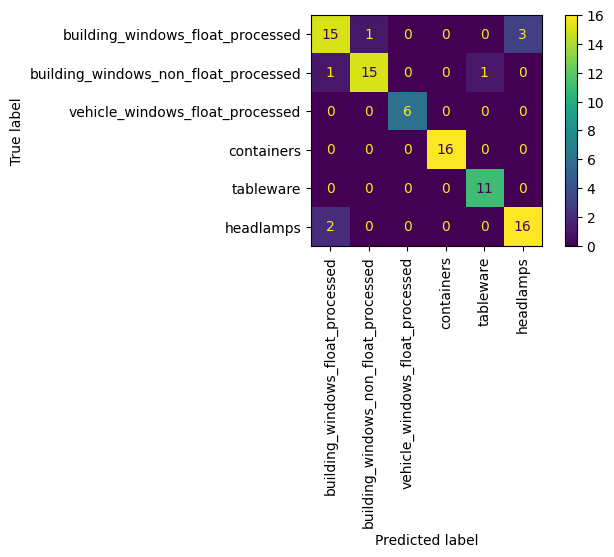

In [73]:
contaminations = np.arange(0.05,0.5, 0.05)
a_base = 0.9
for contamination in contaminations:
  indices = []
  tmp=data.copy()
  start_len=tmp.shape[0]
  X=tmp.drop(columns=['target'])
  y=tmp['target']
  method = f'IsolationForest cont {contamination}'
  iso = IsolationForest(contamination=contamination, random_state=random_seed)
  y_outliers = iso.fit_predict(X)
  # Удаляем выбросы, получаем долю выбросов и их индексы
  for i in range(len(y_outliers)):
      if y_outliers[i] == -1:
          tmp.drop(i, inplace = True)
          indices.append(i)
  share = (len(indices))/start_len*100
  
  if share < percent:
    # пересчитываем модель
    method, report, a = get_learn(tmp,random_seed, method, RandomForestClassifier(criterion='entropy',random_state=random_seed), flag=False )
    if a>= a_base:
      opt_method = method
      opt_share = share
      opt_indices = indices
      opt_a = a
      opt_report = report
      a_base = a

      dict_outliners = dict()
      indices_outliners = dict()
      outliners=data.loc[list(indices)]

      for key, value in class_labels.items():
        dict_outliners[value] = outliners[outliners['target']==value].shape[0]/data.shape[0]*100
        indices_outliners[value] = outliners[outliners['target']==value].index.to_list()
# Фиксируем результаты
df_results.loc[len(df_results.index)] = [opt_method, opt_share, opt_indices, opt_a]

for key, value in class_labels.items():
  dict_outliners[value] = outliners[outliners['target']==value].shape[0]/data.shape[0]*100
  indices_outliners[value] = outliners[outliners['target']==value].index.to_list()
  report_ = opt_report[value]
  exper.loc[len(exper.index)] = [method,  value,  report_['precision'], report_['recall'], report_['f1-score'], dict_outliners[value], indices_outliners[value] ]
print(f'% выбросов по {opt_method} : {opt_share} , a= {opt_a}')  
tmp = data.drop(index= list(opt_indices))
method,  report, a = get_learn(tmp,random_seed, opt_method, RandomForestClassifier(criterion='entropy',random_state=random_seed), flag=True )   

In [74]:
df_results.sort_values(by=['accuracy', 'share'], ascending=False).style.format() \
 .highlight_null(null_color='lightgrey') \
 .highlight_max(color='yellowgreen', subset=['share', 'accuracy']) \
 .highlight_min(color='coral', subset=['share', 'accuracy']) 

,method,share,indices,accuracy
1,CombineTransformer,0.000000,set(),0.945652
2,adjdatatools,0.000000,set(),0.945652
11,OCSVM sclearn rbf 0.08,8.644860,"[0, 70, 103, 105, 106, 107, 109, 110, 111, 112, 131, 163, 166, 171, 172, 173, 184, 185, 186, 201, 220, 225, 228, 231, 240, 245, 247, 250, 261, 263, 265, 270, 273, 281, 349, 357, 360]",0.940476
12,DBSCAN r=2.0 sample=5,1.559020,"[105, 106, 107, 110, 111, 112, 298]",0.933333
13,KNN_sklearn th=0.95,7.675439,[ 70 103 104 105 106 107 108 109 110 111 112 127 128 129 130 131 163 174 184 185 186 188 190 201 207 238 269 273 277 285 298 302 327 360 381],0.917647
9,percentile range,3.728070,"{163, 217, 357, 166, 201, 106, 107, 110, 111, 112, 240, 273, 21, 184, 185, 186, 349}",0.909091
8,3sigma,5.043860,"{131, 261, 265, 201, 270, 273, 349, 225, 163, 228, 357, 166, 103, 360, 106, 107, 110, 47, 111, 112, 240, 245, 184}",0.908046
14,IsolationForest cont 0.05,5.043860,"[103, 105, 106, 107, 110, 111, 112, 131, 163, 171, 172, 174, 184, 185, 186, 189, 231, 250, 263, 281, 323, 349, 357]",0.908046
4,IForest,5.482456,"{196, 324, 325, 6, 9, 137, 77, 207, 84, 21, 219, 284, 158, 97, 291, 36, 359, 360, 106, 299, 108, 236, 42, 50, 123}",0.896552
6,LOF,5.482456,"{64, 257, 194, 67, 196, 5, 325, 9, 137, 274, 84, 344, 284, 93, 158, 97, 36, 357, 359, 106, 42, 174, 244, 53, 251}",0.873563


Для всех вариантов в датафрейме df_results сохранены индексы строк с выбросами. Рассчитаем еще 2 модели - с удалением выбросов, общих для всех вариантов, и с удалением выбросов, найденных у большинства представителей класса ( т.е. выбросов по классам)

In [81]:
min_indices = set()
max_indices = set()
ind = df_results['indices'].to_list()

In [82]:
# Находим минимально возможные выбросы, максимально возможные выбросы и выбросы по классам 
for i in range(len(ind)+1):
  if  (len(ind[i]) >0) & (len(ind[i])<10):
    min_indices = set(ind[i])
    break
for item in ind:
  if  (len(item) >0) & (len(item)<10):
    max_indices.update(set(item))
  if len(item) >0:
    min_indices.intersection_update(set(item))
    # Выбросы, найденные по вем моделям, в сумме составляют 21,5% всех записей.
    # Это слишком много, поэтому возьмем наиболее часто встречающиеся выбросы
    # В количестве, не превышающем 10%

In [83]:
max_indices

{105, 106, 107, 110, 111, 112, 298}

In [84]:
min_indices

{106}

In [85]:
len(max_indices)/data.shape[0]*100

1.5350877192982455

In [86]:
dict_indices=dict()
for item in max_indices:
  dict_indices[item]=0
for item in ind: # берем список индексов выбросов метода
  for el in item: # для каждого индекса в списке
    if el in dict_indices.keys(): # если он естьв списке ключей
      value = dict_indices[el] + 1 
      dict_indices[el] = value

In [87]:
dff = pd.DataFrame.from_dict (dict_indices, orient='index'). reset_index()
dff.columns = ['index', 'count']
max_indices = dff[dff['count']>=5]['index'].to_list()
len(max_indices)

5

In [88]:
dff.sort_values(by=['count'], ascending=False).head(23)

,index,count
2,106,12
3,107,7
6,111,7
0,112,6
5,110,6
1,105,4
4,298,3


In [89]:
# Min_outliers
tmp=data.copy()
X=tmp.drop(columns=['target'])
y=tmp['target']
method = 'Min_outliers'
share = len(min_indices)/tmp.shape[0]*100
print(f'% выбросов по {method}: {share} ')

# Удаляем выбросы и пересчитываем модель
tmp = data.drop(index= list(min_indices))

method,  report, a = get_learn(tmp,random_seed, f'{method}', RandomForestClassifier(criterion='entropy',random_state=random_seed), flag=False )

# Фиксируем результаты
df_results.loc[len(df_results.index)] = [f'{method}', share, set(min_indices), a]

for key, value in class_labels.items():
  dict_outliners[value] = outliners[outliners['target']==value].shape[0]/data.shape[0]*100
  indices_outliners[value] = outliners[outliners['target']==value].index.to_list()
  report_ = report[value]
  exper.loc[len(exper.index)] = [method,  value, report_['precision'], report_['recall'], report_['f1-score'], dict_outliners[value], indices_outliners[value] ]


% выбросов по Min_outliers: 0.21929824561403508 


In [90]:
# Max_outliers
tmp=data.copy()
X=tmp.drop(columns=['target'])
y=tmp['target']
method = 'Max_outliers'
share = len(max_indices)/tmp.shape[0]*100
print(f'% выбросов по {method}: {share} ')
# Удаляем выбросы и пересчитываем модель
tmp = data.drop(index = max_indices)
method,  report, a = get_learn(tmp,random_seed, f'{method}', RandomForestClassifier(criterion='entropy',random_state=random_seed), flag=False )

# Фиксируем результаты
df_results.loc[len(df_results.index)] = [f'{method}', share, set(min_indices), a]

for key, value in class_labels.items():
  dict_outliners[value] = outliners[outliners['target']==value].shape[0]/data.shape[0]*100
  indices_outliners[value] = outliners[outliners['target']==value].index.to_list()
  report_ = report[value]
  exper.loc[len(exper.index)] = [method,  value,  report_['precision'], report_['recall'], report_['f1-score'], dict_outliners[value], indices_outliners[value] ]

% выбросов по Max_outliers: 1.0964912280701753 


# 8. Сформулируйте выводы по проделанной работе.


## а) Кратко опишите, какие преобразования были сделаны с данными.


С данными были выполнены следующие преобразования:
* Признак 'Type' перекодирован в соответствии с весами отдельных классов {2: 76, 1: 70, 7: 29, 3: 17, 5: 13, 6: 9}
* Признаки 'Ba'и 'Fe' подверглись бинаризации ( 0 - элемента нет в составе стекла, 1 - элемент есть)
* Классы целевой переменной были сбалансированы с помошью SMOTE over_sampling
* Признаки ['Mg', 'K'] подверглись стандартизации с помощью StandardScaler
* Прзнаки ['RI',	'Na',	'Al',	'Si',	'Ca'] подверглись трансформации QuantileTransformer с целью приближения их распределения к нормальному
* Кроме того, с целью проверки новых инструментов параллельно была проведена трансформация признаков методом скорректированного интервала при помощи AjustedScaler (библиотека adjdatatools) с получением аналогичных результатов.
* Были испытаны 9 способов поиска выбросов ( библиотека pyod(методы ECOD,IForest, OCSVM, KNN, LOC), прaвило 3 сигм, межквартильный размах, межпроцентильный размах, Махалонобис, Метод опорных векторов(тот же OCSVM, но из sci-kit learn), DBSCAN, KNN, Isolated Forest. Для каждого из способов обучена модель RandomForestClassifier и получен classification_report. 


In [91]:
df_results.sort_values(by=['accuracy', 'share'], ascending=False).style.format() \
 .highlight_null(null_color='lightgrey') \
 .highlight_max(color='yellowgreen', subset=['share', 'accuracy']) \
 .highlight_min(color='coral', subset=['share', 'accuracy']) 

,method,share,indices,accuracy
15,Min_outliers,0.219298,{106},0.956044
1,CombineTransformer,0.000000,set(),0.945652
2,adjdatatools,0.000000,set(),0.945652
11,OCSVM sclearn rbf 0.08,8.644860,"[0, 70, 103, 105, 106, 107, 109, 110, 111, 112, 131, 163, 166, 171, 172, 173, 184, 185, 186, 201, 220, 225, 228, 231, 240, 245, 247, 250, 261, 263, 265, 270, 273, 281, 349, 357, 360]",0.940476
16,Max_outliers,1.096491,{106},0.934066
12,DBSCAN r=2.0 sample=5,1.559020,"[105, 106, 107, 110, 111, 112, 298]",0.933333
13,KNN_sklearn th=0.95,7.675439,[ 70 103 104 105 106 107 108 109 110 111 112 127 128 129 130 131 163 174 184 185 186 188 190 201 207 238 269 273 277 285 298 302 327 360 381],0.917647
9,percentile range,3.728070,"{163, 217, 357, 166, 201, 106, 107, 110, 111, 112, 240, 273, 21, 184, 185, 186, 349}",0.909091
8,3sigma,5.043860,"{131, 261, 265, 201, 270, 273, 349, 225, 163, 228, 357, 166, 103, 360, 106, 107, 110, 47, 111, 112, 240, 245, 184}",0.908046
14,IsolationForest cont 0.05,5.043860,"[103, 105, 106, 107, 110, 111, 112, 131, 163, 171, 172, 174, 184, 185, 186, 189, 231, 250, 263, 281, 323, 349, 357]",0.908046


## b) Сравните точность моделей.


In [109]:
exper.sort_values(by=['class', 'precision','recall'], ascending=False).style\
         .format(precision=2, subset=['precision', 'recall', 'f1-score', '% outliers']) \
         .highlight_null(null_color='lightgrey') \
 .highlight_max(color='yellowgreen', subset=['precision', 'recall', 'f1-score', '% outliers']) \
 .highlight_min(color='coral', subset=['precision', 'recall', 'f1-score', '% outliers']) 

,model,class,precision,recall,f1-score,% outliers,ind_outliers
8,CombineTransformer,vehicle_windows_float_processed,1.00,1.00,1.00,0.00,[]
14,adjdatatools,vehicle_windows_float_processed,1.00,1.00,1.00,0.00,[]
38,LOF,vehicle_windows_float_processed,1.00,1.00,1.00,0.22,[158]
44,KNN,vehicle_windows_float_processed,1.00,1.00,1.00,0.22,[158]
68,OCSVM sclearn rbf 0.4,vehicle_windows_float_processed,1.00,1.00,1.00,0.00,[]
80,KNN_sklearn th=1.5,vehicle_windows_float_processed,1.00,1.00,1.00,0.00,[]
86,IsolationForest cont 0.45,vehicle_windows_float_processed,1.00,1.00,1.00,0.00,[]
92,Min_outliers,vehicle_windows_float_processed,1.00,1.00,1.00,0.00,[]
74,DBSCAN r=1.0 sample=2,vehicle_windows_float_processed,1.00,0.90,0.95,0.00,[]
20,ECOD,vehicle_windows_float_processed,1.00,0.89,0.94,0.44,"[158, 161]"


В датафрейме приведены метрики качества модели при различных способах нахождения выбросов. 
Как видно из датафрейма, удаление выбросов в разумных пределах (не более 10%) во всех случаях приводит к повышению accuracy модели по сравнению с базовым вариантом (без предобработки признаков).
В то же время, лишь обобщение результатов работы всех рассмотренных вариантов позволило подобрать такие выбросы, чтобы accuracy модели получила наибольшее значение.Во всех остальных случаях наилучшую accuracy демонстрирует модель CombineTransformer - без удаления выбросов, но с прекобработкой признаков.

При мультиклассовой классификации не представляется возможным одинаково эффективно предсказывать все классы. Поэтому следует в первую очередь ориентироваться на тот класс, precision и recall по которому наиболее важны, и соответственно выбирать для него лучший способ поиска выбросов.

## c) Напишите свое мнение, нужно ли исследовать данные на выбросы, для чего это делается, плюсы и минусы подхода.

Выбросы искать и удалять нужно. Выбор способа поиска выбросов зависит от многих факторов, в том числе и от того, в какой степени требуется повысить метрики качества модели.
В то же время, трансформация признаков дала значительно больший выигрыш в качестве модели по сравнению с  удалением выбросов.